# VARNN Training Codebase To Share

**Last Updated 3/4/2022**
1. Added VSN updated
2. Added Equation-by-Equation
3. Added support for different hemispheres
4. Execution Code Updated for different num variables, different methods of specifying hyperparams

In [1]:
!pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 5.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from tqdm.notebook import tqdm, trange
import copy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from functools import reduce
from itertools import product

from sklearn.linear_model import LinearRegression
import random
from datetime import datetime

from statsmodels.tsa.api import VAR

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = 'drive/MyDrive/EconML DL/Fall 2021'

## Parameters for Model

### Variable Selection Networks

In [5]:
# @title VSN Code

# num_features = variables here
# units = encoding dimension of each feature

class GatedLinearUnit(nn.Module):
  def __init__(self, input_size, units):
    super(GatedLinearUnit, self).__init__()
    self.linear1 = nn.Linear(input_size, units)
    self.linear2 = nn.Linear(input_size, units)
    self.sigmoid = nn.Sigmoid()

    self.input_size = input_size

  def forward(self, inputs):
    #print('glu input size', self.input_size)
    #print('glu input', inputs.shape)
    linear = self.linear1(inputs)
    sigmoid = self.sigmoid(self.linear2(inputs))
    # Element-wise product of linear layer and sigmoid layer
    out = linear * sigmoid
    #print('out', out.shape)
    return out

class GatedResidualNetwork(nn.Module):
  def __init__(self, input_size, units, dropout_rate):
    super(GatedResidualNetwork, self).__init__()
    self.elu_linear = nn.Linear(input_size, units)
    self.elu = nn.ELU()
    self.linear = nn.Linear(units, units)
    self.dropout = nn.Dropout(dropout_rate)
    self.gated_linear_unit = GatedLinearUnit(units, units)
    self.layer_norm = nn.LayerNorm(units)
    self.project = nn.Linear(input_size, units)
    
    self.input_size = input_size
    self.units = units
    
  def forward(self, inputs):
    #print('grn input size', self.input_size)
    #print('grn input', inputs.shape)
    x = self.elu_linear(inputs)
    x = self.elu(x)
    x = self.linear(x)
    x = self.dropout(x)
    # Add the original units to output of GLU to perform residual connection
    #print('x_size', x.shape)
    if inputs.shape[-1] != self.units:
      inputs = self.project(inputs)
    x = inputs + self.gated_linear_unit(x)
    x = self.layer_norm(x)
    return x

# NEW VSN
class VariableSelection(nn.Module):
  def __init__(self, num_features, units, dropout_rate):
    super(VariableSelection, self).__init__()

    # Create a GRN for the concatenation of all the features
    self.grn_concat = GatedResidualNetwork(num_features, units, dropout_rate)
    self.softmax_linear = nn.Linear(units, num_features)

  def forward(self, inputs):
    # Code for this may be questionable
    #v = torch.cat(inputs)

    # size: num_obs x (features x units)
    v = self.grn_concat(inputs)
    # size: num_obs x units
    v = self.softmax_linear(v)
    v = F.softmax(v, dim = -1)
    # size: num_obs x features
    return v

### VARNN Code

In [6]:
# @title CancelOut

class CancelOut(nn.Module):
    '''
    CancelOut Layer
    x - an input data (vector, matrix, tensor)
    '''
    def __init__(self,inp, *kargs, **kwargs):
        super(CancelOut, self).__init__()
        self.weights = nn.Parameter(torch.zeros(inp,requires_grad = True) + 4)
    def forward(self, x):
        return (x * torch.sigmoid(self.weights.float()))

In [7]:
# @title Fully Connected Network Architecture

class FCN(nn.Module):
  def __init__(self, n_features, n_outputs, dropout_rate, nodes, actv):
    super(FCN, self).__init__()

    # Assign the activation function
    exec('self.actv = %s'%actv)

    self.input = nn.Linear(n_features, nodes[0])
    self.hidden = nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)])
    self.output = nn.Linear(nodes[-1], n_outputs)
    self.dropout = nn.Dropout(p = dropout_rate)

  def forward(self, S):

    x = self.actv(self.input(S))
    x = self.dropout(x)

    for i in range(len(self.hidden)):
      x = self.actv(self.hidden[i](x))
      x = self.dropout(x)
    
    output = self.output(x)
    return output

**VARNN Notes**
- Input Dropout currently not working
- Prior shift currently not working (after hemispheres)

In [8]:
# @title VAR NN Architecture Definition

class VARNN(nn.Module):
    def __init__(self, n_features, n_outputs, nodes, x_pos, dropout_rate, input_dropout_rate, 
                 cancel_out, vsn, fcn, neurons_weights, time_hemi_prior_variance,
                 device, actv = 'ReLU()', s_pos = None):
        super(VARNN, self).__init__()

        n_betas = []
        x_indices = []
        self.n_vars = len(x_pos)

        # Assign the activation function
        exec('self.actv = %s'%actv)
        
        s_indices = []
        for i in range(len(s_pos)):
          s_indices.append(torch.tensor(s_pos[i], dtype = torch.int64).to(device))
        self.s_pos = s_indices

        for i in range(self.n_vars):
          x_indices.append(torch.tensor(x_pos[i], dtype = torch.int64).to(device))
          n_betas.append(len(x_pos[i]))

        self.n_betas = n_betas
        self.n_alphas = int(n_outputs * (n_outputs+1) / 2)

        # Hemispheres
        # Number of hemispheres is number of lists within the s_pos list
        self.num_hemispheres = len(self.s_pos)
        self.time_hemi_prior_variance = time_hemi_prior_variance

        self.hemispheres = nn.ModuleList()

        for hemi_id in range(self.num_hemispheres):

          hemi_num_inputs = len(self.s_pos[hemi_id])

          # Defining the TVPL and Output layers - BETAS
          tvpl_all = []
          output_all = []

          for i in range(n_outputs):
            tvpl_var = []
            output_var = []
            for tvpl_archi in neurons_weights:
              # Define the TVPL NN for one layer 
              tvpl_list = [nn.Linear(nodes[-1], tvpl_archi[0])]
              for layer_id in range(len(tvpl_archi) - 1):
                tvpl_list.append(nn.Linear(tvpl_archi[layer_id], tvpl_archi[layer_id+1]))
              tvpl_var.append(nn.ModuleList(tvpl_list))
              output_var.append(nn.Linear(tvpl_archi[-1], 1))
            tvpl_all.append(nn.ModuleList(tvpl_var))
            output_all.append(nn.ModuleList(output_var))      

          # Defining TVPL and Output layers - ALPHAS
          tvpl_alphas = []
          output_alphas = []
          for i in range(self.n_alphas):
            # Just use the 1st tvpl archi for now - could change later
            tvpl_archi = neurons_weights[0]
            tvpl_list = [nn.Linear(nodes[-1], tvpl_archi[0])]
            for layer_id in range(len(tvpl_archi) - 1):
              tvpl_list.append(nn.Linear(tvpl_archi[layer_id], tvpl_archi[layer_id+1]))
            tvpl_alphas.append(nn.ModuleList(tvpl_list))
            output_alphas.append(nn.Linear(tvpl_archi[-1], 1))

            
          self.hemispheres.append(
              nn.ModuleDict({
              'betas': nn.ModuleDict({
                'input': nn.Linear(hemi_num_inputs, nodes[0]).to(device),
                'first': nn.Linear(nodes[0], nodes[0]).to(device),
                'hidden': nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)]).to(device),
                'tvpl': nn.ModuleList(tvpl_all).to(device),
                'output': nn.ModuleList(output_all).to(device)
              }),
              'alphas': nn.ModuleDict({
                'input': nn.Linear(hemi_num_inputs, nodes[0]).to(device),
                'first': nn.Linear(nodes[0], nodes[0]).to(device),
                'hidden': nn.ModuleList([nn.Linear(nodes[node_id], nodes[node_id+1]) for node_id in range(len(nodes)-1)]).to(device),
                'tvpl': nn.ModuleList(tvpl_alphas).to(device),
                'output': nn.ModuleList(output_alphas).to(device)
              })
              }))

        self.dropout = nn.Dropout(p = dropout_rate)
        self.input_dropout = nn.Dropout(p = 0)
        self.input_dropout_enabled = input_dropout_rate == 0
        self.device = device

        # Instantiate the VSN or FCN networks if applicable
        if vsn == True:
          #print('n_features', n_features, 'n_outputs', n_outputs)
          self.vsn = VariableSelection(n_features, n_outputs, input_dropout_rate)
          pytorch_total_params = sum(p.numel() for p in self.vsn.parameters())
        else:
          self.vsn = None

        if fcn == True:
          self.fcn = FCN(n_features, n_outputs, dropout_rate, nodes, actv)
          pytorch_total_params = sum(p.numel() for p in self.fcn.parameters())
        else:
          self.fcn = None

        self.vsn_enabled = vsn
        self.fcn_enabled = fcn

        self.x_indices = x_indices
        self.n_layers = len(nodes)
        
        self.n_outputs = n_outputs
        self.neurons_weights = neurons_weights

    def forward(self, S):
      
      # Get the Xs for the linear part
      dat = torch.index_select(S, 1, self.x_indices[0])
      for i in range(1, self.n_vars):
        alt = torch.index_select(S, 1, self.x_indices[i])
        dat = torch.hstack([dat, alt])
      
      # Append constant column at the front
      dat = torch.hstack([torch.ones(S.size()[0], 1).to(self.device), dat])

      # Pure Fully-connected network if only that is enabled
      if self.fcn_enabled == True:
        y_hat = self.fcn(S)
        return y_hat, [], []

      # Pure VSN layer if only that is enabled
      if self.vsn_enabled == True:
        #print('input to vsn', S.shape)
        v = self.vsn(S)
        # NEW
        v = torch.mean(v, dim = 0)
        v_out = v.unsqueeze(0).repeat(S.shape[0],1) #becomes n_inputs x 1 -> 1 x n_inputs -> n_obs x n_inputs
        # S: n_obs x n_inputs
        S = torch.mul(S, v_out)
      else:
        v = []

      # Then do input layer dropout if activated
      # if self.input_dropout_enabled == True:
      #   S = self.input_dropout(S)

      betas_hemispheres = []
      alphas_hemispheres = []

      for hemi_id in range(self.num_hemispheres):
        # Subset the data going into that hemispheres
        S_hemi = torch.index_select(S, 1, self.s_pos[hemi_id])

        # Divide everything by the sqrt of number of parameters in hemisphere
        num_params = len(self.s_pos[hemi_id])
        S_hemi = S_hemi / (num_params ** 0.5)

        # Multiply by time hemisphere prior variance
        if self.num_hemispheres > 1 and hemi_id == self.num_hemispheres - 1:
          S_hemi = S_hemi * (self.time_hemi_prior_variance ** 2)
        
        # BETAS: Pass the data through beta hemispheres, output betas

        x = self.actv(self.hemispheres[hemi_id]['betas']['input'](S_hemi))
        x = self.dropout(x)
        # Hidden layers
        x = self.actv(self.hemispheres[hemi_id]['betas']['first'](x))
        x = self.dropout(x)
        if self.n_layers > 1:
          for i in range(self.n_layers - 1):
            x = self.actv(self.hemispheres[hemi_id]['betas']['hidden'][i](x))
            x = self.dropout(x)

        betas = []

        for i in range(self.n_outputs):
          # For intercept
          x_i = torch.clone(x)
          for l in range(len(self.hemispheres[hemi_id]['betas']['tvpl'][i][0])):
            x_i = self.actv(self.hemispheres[hemi_id]['betas']['tvpl'][i][0][l](x_i))
          betas_alt = self.hemispheres[hemi_id]['betas']['output'][i][0](x_i)
          del x_i

          # For betas on the variables
          for j in range(1, sum(self.n_betas) + 1):
            x_b = torch.clone(x)
            for l in range(len(self.hemispheres[hemi_id]['betas']['tvpl'][i][j])):
              x_b = self.actv(self.hemispheres[hemi_id]['betas']['tvpl'][i][j][l](x_b))
            alt = self.hemispheres[hemi_id]['betas']['output'][i][j](x_b)
            betas_alt = torch.cat([betas_alt, alt], dim = 1)
            del x_b
          betas.append(betas_alt)
          
        # betas
        betas_combined = torch.stack(betas, axis = 1)
        betas_hemispheres.append(betas_combined)

        # ALPHAS: Pass the data through alpha hemispheres, output alphas
        x = self.actv(self.hemispheres[hemi_id]['alphas']['input'](S_hemi))
        x = self.dropout(x)
        # Hidden layers
        x = self.actv(self.hemispheres[hemi_id]['alphas']['first'](x))
        x = self.dropout(x)
        if self.n_layers > 1:
          for i in range(self.n_layers - 1):
            x = self.actv(self.hemispheres[hemi_id]['alphas']['hidden'][i](x))
            x = self.dropout(x)

        alphas = []

        for i in range(self.n_alphas):
          x_a = torch.clone(x)
          for l in range(len(self.hemispheres[hemi_id]['alphas']['tvpl'][i])):
            x_a = self.actv(self.hemispheres[hemi_id]['alphas']['tvpl'][i][l](x_a))
          alphas_alt = self.hemispheres[hemi_id]['alphas']['output'][i](x_a)
          del x_a
          alphas.append(alphas_alt)
        
        alphas_combined = torch.stack(alphas, axis = 1)
        alphas_hemispheres.append(alphas_combined)
      
      # Impose that the mean of the endog hemisphere is 0
      if len(betas_hemispheres) == 2:
        endog_hemi = betas_hemispheres[0]
        exog_hemi = betas_hemispheres[1]
        
        # hemi dim: n_obs x n_var x n_betas
        # Take the mean of the endog hemi over time
        endog_hemi_mean = torch.nanmean(endog_hemi, axis = 0)
        # Impose the endog hemi mean to be 0
        endog_hemi = endog_hemi - endog_hemi_mean
        exog_hemi = exog_hemi + endog_hemi_mean

        betas_hemispheres = [endog_hemi, exog_hemi]

      # Reorder alphas to the cholesky matrix
      cholesky_hemispheres = []
      for alpha_hemi in alphas_hemispheres:
        alpha_hemi = alpha_hemi.squeeze(-1)
        # Construct precision matrix from the alphas
        n_vars = self.n_outputs
        # Lower-triangular Ct matrix
        c_t = torch.zeros((alpha_hemi.shape[0], n_vars, n_vars))
        i = 0
        for row in range(n_vars):
          for col in range(row+1):
            if row == col:
              # Absolute value for the diagonal elements of the cholesky matrix (6/2)
              c_t[:, row, col] = torch.abs(alpha_hemi[:, i])
            else:
              c_t[:, row, col] = alpha_hemi[:, i]
            i+=1
        cholesky_hemispheres.append(c_t)
      
      # Combine results from different hemispheres (general reduce function to allow for mult or sum)
      # Now we are using sum
      betas_reduced = reduce(lambda x, y: x + y, betas_hemispheres)
      cholesky_reduced = reduce(lambda x, y: x + y, cholesky_hemispheres)
      

      #c_t = n_obs x n_vars x n_vars
      # Multiply by transpose to get precision matrix
      precision = torch.bmm(cholesky_reduced, torch.permute(cholesky_reduced, (0, 2, 1)))
      
      # Generate predictions for this period (i.e. y_hat)
      y_hat = torch.unsqueeze(torch.sum(torch.mul(dat, betas_reduced[:, 0, :]), dim = 1), 1)
      
      for i in range(1, self.n_outputs):
        alt = torch.unsqueeze(torch.sum(torch.mul(dat, betas_reduced[:, i, :]), dim = 1), 1)
        y_hat = torch.hstack([y_hat, alt])

      with torch.no_grad():
        betas_hemispheres_stacked = torch.stack(betas_hemispheres, axis = -1)
        betas_hemispheres_stacked = torch.permute(betas_hemispheres_stacked, (0, 2, 1, 3))

        cholesky_hemispheres_stacked = torch.stack(alphas_hemispheres, axis = -1)


      return y_hat, precision, betas_hemispheres_stacked, cholesky_hemispheres_stacked, v

In [9]:
# @title Training Loop (with New Loss)

def training_loop_new(X_train, Y_train, model, criterion, optimizer, scheduler, train_indices, nn_hyps):

  num_epochs = nn_hyps['epochs']
  loss_weights = nn_hyps['loss_weights']
  n_vars = Y_train.shape[1]

  wait = 0
  best_epoch = 0
  best_loss = float('inf')
  
  # Loss matrix, dim: num_epochs x num_variables
  loss_matrix = np.empty((num_epochs, n_vars))
  loss_matrix[:] = np.nan
  loss_matrix_oob = np.empty((num_epochs, n_vars))
  loss_matrix_oob[:] = np.nan

  # Get the OOB indices (not in train_indices)
  oob_indices = [e for e in range(X_train.shape[0]) if e not in train_indices]
  train_losses = []
  oob_losses = []
  oob_mse = []
  
  v_matrix = np.empty((num_epochs, X_train.shape[1]))

  for epoch in range(num_epochs):

    loss_vars = []
    loss_vars_oob = []

    model.train()
    optimizer.zero_grad()

    if nn_hyps['joint_estimation'] == False:
      ## Getting in-sample errors
      for var in range(n_vars): # Loop through all variables
        Y_pred, _, betas, _, v = model(X_train[train_indices, :])
        loss = criterion(Y_pred[:, var], Y_train[train_indices, var])
        loss_matrix[epoch, var] = float(loss)
        w = (loss_weights[0] / loss_weights[var]) ** nn_hyps['loss_weight_param']
        loss = loss * w
        loss_vars.append(loss)
        
        if type(v) is list:
          pass
        else:
          v_matrix[epoch, :] = v.detach().cpu().numpy()

      loss = torch.mean(torch.hstack(loss_vars))
      l1_input = l1_reg_input(model) 
      l1_input_loss = l1_input * nn_hyps['l1_input_lambda']
      l0_input = l0_reg_input(model)
      l0_input_loss = l0_input * nn_hyps['l0_input_lambda']
      loss += (l1_input_loss + l0_input_loss)

      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(float(loss))

      model.eval()
  
      # Get OOB loss
      for var in range(n_vars):
        Y_pred_oob, _, _, _, _ = model(X_train[oob_indices, :])
        loss_oob = criterion(Y_pred_oob[:, var], Y_train[oob_indices, var])
        loss_matrix_oob[epoch, var] = float(loss_oob)
        w = (loss_weights[0] / loss_weights[var]) ** nn_hyps['loss_weight_param']
        loss_oob = loss_oob * w
        loss_vars_oob.append(loss_oob)

      loss_oob = torch.mean(torch.hstack(loss_vars_oob))
      oob_losses.append(float(loss_oob))

      if epoch % 40 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}, OOB Loss: {loss_oob}')


    else: # Joint estimation
      Y_pred, precision, betas, alphas, v = model(X_train[train_indices, :])

      # Get the residuals
      residuals = Y_pred - Y_train[train_indices, :]
      precision = precision.to(device)

      # Regularization to the precision matrix
      precision = precision + torch.eye(n_vars).to(device) * nn_hyps['precision_lambda']

      det_p = torch.linalg.det(precision).to(device)
      temp = torch.bmm(residuals.unsqueeze(1), precision)
      out = torch.bmm(temp, residuals.unsqueeze(2))
      mean_log_det_p = torch.mean(torch.log(det_p))
      loss = -nn_hyps['log_det_multiple'] * mean_log_det_p + torch.mean(out.squeeze())

      mse = torch.mean(torch.bmm(residuals.unsqueeze(1), residuals.unsqueeze(2)))

      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(float(loss))

      model.eval()

      # Get OOB Loss 
      Y_pred, precision, betas, alphas, v = model(X_train[oob_indices, :])
      residuals = Y_pred - Y_train[oob_indices, :]
      precision = precision.to(device)
      # Regularization to the precision matrix
      precision = precision + torch.eye(n_vars).to(device) * nn_hyps['precision_lambda']
      det_p = torch.linalg.det(precision).to(device)
      temp = torch.bmm(residuals.unsqueeze(1), precision)
      out = torch.bmm(temp, residuals.unsqueeze(2))
      mean_log_det_p = torch.mean(torch.log(det_p))
      loss_oob = -nn_hyps['log_det_multiple'] * mean_log_det_p + torch.mean(out.squeeze())
      
      mse = torch.mean(torch.bmm(residuals.unsqueeze(1), residuals.unsqueeze(2)))
      if epoch % 40 == 0:
        print(f'OOB Mean Log Det Precision: {mean_log_det_p}, MSE: {mse}')

      oob_losses.append(float(loss_oob))
      oob_mse.append(float(mse))

      if epoch % 40 == 0:
        lr_now = optimizer.param_groups[0]['lr']
        print(f'Epoch: {epoch}, Loss: {loss}, OOB Loss: {loss_oob}, LR: {lr_now}')

    ## Early Stopping

    pct_change = (best_loss - loss_oob) / loss_oob 
    # If current epoch improved on the best OOB loss, update best_loss, best_epoch and best_model to current
    if best_loss > loss_oob or epoch == 0:
      best_loss = loss_oob
      best_epoch = epoch
      best_model = copy.deepcopy(model)

      # If model improved more than tol, set wait to 0
      if pct_change > nn_hyps['tol'] or epoch == 0:
        wait = 0
      else: # If model improve less than tol, increment wait
        wait = wait + 1
    else: # If current epoch did not improve, increment wait
      wait = wait + 1

    # Early stopping if wait exceeds patience
    if wait > nn_hyps['patience']:
      lr_end = optimizer.param_groups[0]['lr']
      print(f'Early stopped, best epoch: {best_epoch}, train loss: {train_losses[best_epoch]}, best OOB loss: {best_loss}, LR: {lr_end}')
      break

  # Plot the training curves
  plt.figure()

  ax1 = plt.subplot()
  l1, = ax1.plot(train_losses[1:], label = 'Train Loss', color = 'blue')
  l2, = ax1.plot(oob_losses[1:], label = 'OOB Loss', color = 'orange')
  ax2 = ax1.twinx()
  l3, = ax2.plot(oob_mse[1:], label = 'OOB MSE', color = 'red')
  plt.legend([l1, l2, l3], ['Train Loss', 'OOB Loss', 'OOB MSE'])
  plt.show()

  out = {
         'best_model': best_model,
         'v': v_matrix,
         'loss_matrix': loss_matrix,
         'loss_matrix_oob': loss_matrix_oob,
         'best_train_loss': train_losses[best_epoch],
         'best_oob_loss': best_loss}

  return out

### Calculate the Loss Weights (by running the Autoregression separately for each variable on training data)
def get_mse_weights(X, Y, n_lags, trend = 't'):

  mse_weights = []
  # For each Y variable
  for i in range(Y.shape[1]):
    y = Y[:, i]
    res = AutoReg(y, lags = n_lags, trend = 't').fit()
    # Get predictions
    y_pred = res.predict(start = 0, end = -1)
    # Get MSE
    mse = np.mean((y_pred - y[n_lags:]) ** 2)
    mse_weights.append(mse)

  return mse_weights

In [10]:
# @title Scaling Functions and L1/L0

# Scale data
def scale_data(X_train, Y_train, X_test, Y_test):
  # Standardize the variables
  scaler_x = StandardScaler()
  X_train_scaled = scaler_x.fit_transform(X_train)
  X_test_scaled = scaler_x.transform(X_test)

  scaler_y = StandardScaler()
  Y_train_scaled = scaler_y.fit_transform(Y_train)
  Y_test_scaled = scaler_y.transform(Y_test)

  # Warning: sigma_x gives slightly different values from the R version (could be due to estimator of variance n-1)

  return {
      'X_train': X_train_scaled,
      'X_test': X_test_scaled,
      'Y_train': Y_train_scaled,
      'Y_test': Y_test_scaled,
      'mu_x': scaler_x.mean_,
      'sigma_x': np.sqrt(scaler_x.var_),
      'mu_y': scaler_y.mean_,
      'sigma_y': np.sqrt(scaler_y.var_),
      'scaler_x': scaler_x,
      'scaler_y': scaler_y
  }

# Invert scaling
def invert_scaling(scaled, mu, sigma):
  inverted = scaled * sigma + mu
  return inverted

def l1_reg_input(model):
  l1 = 0
  for name, param in model.named_parameters():
    if name == 'input.weight':
      l1 += torch.sum(torch.abs(param))
      break
  return l1
  
  
def l0_reg_input(model, tol = 1e-5):
  l0 = 0
  for name, param in model.named_parameters():
    if name == 'input.weight':
      l0 += torch.sum(torch.abs(param) > tol)
      break
  return l0

### VARNN Code

In [11]:
# @title VARNN Training Wrapper Function

def build_VARNN(X, Y, train_indices, nn_hyps, device):

  if nn_hyps['s_pos']:
    s_pos = list(itertools.chain(*nn_hyps['s_pos']))
    n_features = len(s_pos)
  else:
    n_features = X.shape[1]

  n_outputs= len(nn_hyps['x_pos'])
  if nn_hyps['eqn_by_eqn'] == True:
    models = []
    results_all = []
    for var in range(n_outputs):
      print(f'Start Estimating Equation {var}')
      model = VARNN(n_features = n_features, 
                n_outputs= 1,
                nodes = nn_hyps['nodes'],
                x_pos = nn_hyps['x_pos'],
                dropout_rate = nn_hyps['dropout_rate'],
                input_dropout_rate = nn_hyps['input_dropout_rate'],
                cancel_out = nn_hyps['cancel_out'],
                vsn = nn_hyps['vsn'],
                fcn = nn_hyps['fcn'],
                neurons_weights = nn_hyps['neurons_weights'],
                time_hemi_prior_variance = nn_hyps['time_hemi_prior_variance'],
                actv = nn_hyps['actv'],
                device = device,
                s_pos = nn_hyps['s_pos'])
      models.append(model)
      pytorch_total_params = sum(p.numel() for p in model.parameters())
      print('Approximate NN size (MB): ', pytorch_total_params * 64 / 1024 / 1024)

      criterion = nn.MSELoss()
      optimizer = nn_hyps['optimizer']
      if optimizer == 'RMSprop':
        optimizer_obj = optim.RMSprop(model.parameters(), lr = nn_hyps['lr'])
      elif optimizer == 'SGD':
        optimizer_obj = optim.SGD(model.parameters(), lr = nn_hyps['lr'])
      elif optimizer == 'RAdam':
        optimizer_obj = optim.RAdam(model.parameters(), lr = nn_hyps['lr'])
      else:
        optimizer_obj = optim.Adam(model.parameters(), lr = nn_hyps['lr'])

      lmda = lambda epoch: nn_hyps['lr_multiple']
      scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_obj, lr_lambda = lmda)
      model = model.to(device)
      
      # Train the built VARNN on one variable and return the results
      results = training_loop_new(X, Y[:,var:(var+1)], model, criterion, optimizer_obj, scheduler, train_indices, nn_hyps)
      results_all.append(results)
    return results_all

  else:
    model = VARNN(n_features = n_features, 
                  n_outputs= len(nn_hyps['x_pos']), 
                  nodes = nn_hyps['nodes'],
                  x_pos = nn_hyps['x_pos'],
                  dropout_rate = nn_hyps['dropout_rate'],
                  input_dropout_rate = nn_hyps['input_dropout_rate'],
                  cancel_out = nn_hyps['cancel_out'],
                  vsn = nn_hyps['vsn'],
                  fcn = nn_hyps['fcn'],
                  neurons_weights = nn_hyps['neurons_weights'],
                  time_hemi_prior_variance = nn_hyps['time_hemi_prior_variance'],
                  actv = nn_hyps['actv'],
                  device = device,
                  s_pos = nn_hyps['s_pos'])
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print('Approximate NN size (MB): ', pytorch_total_params * 64 / 1024 / 1024)
      
    criterion = nn.MSELoss()

    optimizer = nn_hyps['optimizer']
    if optimizer == 'RMSprop':
      optimizer_obj = optim.RMSprop(model.parameters(), lr = nn_hyps['lr'])
    elif optimizer == 'SGD':
      optimizer_obj = optim.SGD(model.parameters(), lr = nn_hyps['lr'])
    elif optimizer == 'RAdam':
      optimizer_obj = optim.RAdam(model.parameters(), lr = nn_hyps['lr'])
    else:
      optimizer_obj = optim.Adam(model.parameters(), lr = nn_hyps['lr'])


    lmda = lambda epoch: nn_hyps['lr_multiple']
    scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_obj, lr_lambda = lmda)

    # scheduler = optim.lr_scheduler.CyclicLR(optimizer_obj, base_lr = nn_hyps['lr'] / 2, max_lr = nn_hyps['lr'] * 4, 
    #                                         step_size_up = 50, 
    #                                         step_size_down = 50, cycle_momentum = False)
    
    model = model.to(device)
    
    # Training the built VARNN and return the results
    results = training_loop_new(X, Y, model, criterion, optimizer_obj, scheduler, train_indices, nn_hyps)
    
    return results

In [12]:
# @title VARNN Inner Bootstrap Function

# Build_VARNN() is a helper function used within this wrapper function
def conduct_bootstrap(X_train, X_test, Y_train, Y_test, nn_hyps, device):

  x_pos_flat = list(itertools.chain(*nn_hyps['x_pos']))

  n_obs = X_train.shape[0]
  n_vars = Y_train.shape[1]
  n_betas = len(x_pos_flat) + 1
  n_hemispheres = len(nn_hyps['s_pos'])

  # Conduct prior shift
  if nn_hyps['prior_shift'] == True:
    x_pos_ps = sorted(list(itertools.chain(*nn_hyps['x_pos_ps'])))

    # Isolate the lags that we calculate PS from
    X_train_temp = X_train[:, x_pos_ps]
    # Add constant
    X_train_temp = sm.add_constant(X_train_temp)

    # Run linear regression, get the betas
    lin_reg = sm.OLS(Y_train, X_train_temp)
    ps_model = lin_reg.fit()

    X_test_temp = X_test[:, x_pos_ps]
    X_test_temp = sm.add_constant(X_test_temp)
    # Get predictions of var.fitted
    Y_train_fitted = ps_model.predict(X_train_temp)
    Y_test_fitted = ps_model.predict(X_test_temp)

    # Multiply predictions by the strength parameter
    Y_train_fitted = Y_train_fitted * nn_hyps['prior_shift_strength']
    Y_test_fitted = Y_test_fitted * nn_hyps['prior_shift_strength']

    # Subtract fitted values to get residuals
    Y_train = Y_train - Y_train_fitted
    Y_test = Y_test - Y_test_fitted

  else:
    ps_model = None
    x_pos_ps = None
    Y_train_fitted = 0.0
    Y_test_fitted = 0.0

  # Scaling
  if nn_hyps['standardize'] == True:
    scale_output = scale_data(X_train, Y_train, X_test, Y_test)
    X_train = scale_output['X_train']
    X_test = scale_output['X_test']
    Y_train = scale_output['Y_train']
    Y_test = scale_output['Y_test']

  # Get the loss weights
  mse_weights = get_mse_weights(X_train, Y_train, n_lags = nn_hyps['n_lag_linear'])
  nn_hyps.update({'loss_weights': mse_weights})

  # Convert to tensors
  X_train = torch.tensor(np.array(X_train), dtype = torch.float).to(device)
  X_test = torch.tensor(np.array(X_test), dtype = torch.float).to(device)
  Y_train = torch.tensor(np.array(Y_train), dtype = torch.float).to(device)
  Y_test = torch.tensor(np.array(Y_test), dtype = torch.float).to(device)

  ### 3: Conduct Bootstrapping

  num_bootstrap = nn_hyps['num_bootstrap']
  opt_bootstrap = nn_hyps['opt_bootstrap']
  sampling_rate = nn_hyps['sampling_rate']
  block_size = nn_hyps['block_size']
  bootstrap_indices = nn_hyps['bootstrap_indices']
  oob_loss_multiple_threshold = nn_hyps['oob_loss_multiple_threshold']

  # Matrix to store all predictions for every bootstrap run
  # pred_in_ensemble are the OOB results, pred_ensemble are the test results
  pred_in_ensemble = np.empty((X_train.shape[0], num_bootstrap, n_vars))
  pred_in_ensemble[:] = np.nan
  pred_ensemble = np.empty((X_test.shape[0], num_bootstrap, Y_test.shape[1]))
  pred_ensemble[:] = np.nan

  # Matrix to store ensembled predictions
  pred_in = np.empty((X_train.shape[0], n_vars))
  pred_in[:] = np.nan
  pred = np.empty((X_test.shape[0], Y_test.shape[1]))
  pred[:] = np.nan

  # Store the errors
  mse_in_ensemble = np.empty(num_bootstrap)
  mse_in_ensemble[:] = np.nan
  mse_ensemble = np.empty(num_bootstrap)
  mse_ensemble[:] = np.nan
  
  # Matrix to store all betas: dim is len(X) x n_betas (n_vars+1) x n_bootstraps x n_vars
  betas_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                          n_betas,
                          num_bootstrap,
                          n_vars, n_hemispheres))
  betas_in_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                          n_betas,
                          num_bootstrap,
                          n_vars, n_hemispheres))
  betas_draws[:] = np.nan
  betas_in_draws[:] = np.nan

  # Matrix to store all sigmas
  sigmas_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                           n_vars, n_vars,
                           num_bootstrap))
  sigmas_in_draws = np.empty((X_train.shape[0] + X_test.shape[0], 
                           n_vars, n_vars,
                           num_bootstrap))
  sigmas_draws[:] = np.nan
  sigmas_in_draws[:] = np.nan

  # Matrix to store precision matrix and choleksy of precision
  precision_draws = np.zeros_like(sigmas_draws)
  precision_in_draws = np.zeros_like(sigmas_in_draws)
  precision_draws[:] = np.nan
  precision_in_draws[:] = np.nan

  cholesky_draws = np.zeros_like(sigmas_draws)
  cholesky_in_draws = np.zeros_like(sigmas_in_draws)
  cholesky_draws[:] = np.nan
  cholesky_in_draws[:] = np.nan
  
  # Store models and values
  trained_model = []
  v_matrix = []
  bootstrap_indexes = []

  accepted_bootstraps = 0
  ## 3A: Sample bootstrap indices
  # For each bootstrap iteration, choose the training indices (boot), and the oob
  # oos is just the testing indices
  # Then conduct the model training, and save the results
  for j in range(num_bootstrap):

    print(f'Bootstrap iteration {j} at time {datetime.now()}')

    if bootstrap_indices: # If bootstrap indices are provided in nn_hyps, then no need to sample inside
      boot = bootstrap_indices[j]['in_sample']
      oob = bootstrap_indices[j]['oob']
      oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))
    
    else: # Sample the bootstraps
      if opt_bootstrap == 1: # Individual obs bootstrap
        k = int(sampling_rate * X_train.shape[0])

        boot = sorted(random.sample(list(range(X_train.shape[0])), k = k))
        oob = [e for e in list(range(X_train.shape[0])) if e not in boot]
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))

      if opt_bootstrap == 2: # Block bootstrap
        # Select the size of first block
        first_block_size = random.sample(list(range(int(block_size / 2), block_size + 1)), k = 1)[0]
        # Get the starting ids of the blocks
        block_start_ids = [0] + list(range(first_block_size, n_obs, block_size))

        # If last block size < half of block size
        last_block_size = n_obs - block_start_ids[-1]
        if last_block_size < block_size / 2:
          block_start_ids.remove(block_start_ids[-1])

        num_oob_blocks = int(((1-sampling_rate) * n_obs) / block_size)
        oob_blocks = random.sample(list(range(len(block_start_ids))), k = num_oob_blocks)
        # Get the OOB indices
        oob = list(itertools.chain(*[list(range(block_start_ids[e], block_start_ids[e+1])) if e < len(block_start_ids) - 1 else list(range(block_start_ids[e], n_obs)) 
          for e in oob_blocks]))
        
        boot = [e for e in list(range(n_obs)) if e not in oob]
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))

      if sampling_rate == 1:
        boot = sorted(random.sample(list(range(X_train.shape[0])), k = k))
        oob = range(X_train.shape[0])
        oos = list(range(X_train.shape[0], X_train.shape[0] + X_test.shape[0]))
    
    models = []
    # 3B: Use the bootstrap indices as the training indices for the model
    if nn_hyps['eqn_by_eqn'] == False:
      model_out = build_VARNN(X_train, Y_train, boot, nn_hyps, device)
      model = model_out['best_model'].to(device)

      # Save the trained models (for multi-horizon prediction)
      trained_model.append(model)
    else:
      models_out = build_VARNN(X_train, Y_train, boot, nn_hyps, device)
      for e in models_out:
        models.append(e['best_model'].to(device))
    
    # Reject the model if the OOB loss is much higher than train loss
    # oob_loss_multiple = model_out['best_oob_loss'] / model_out['best_train_loss']
    # if oob_loss_multiple > oob_loss_multiple_threshold:
    if False:
      print(f'Rejected inner bootstrap {j}, ratio: {oob_loss_multiple}')
    else:
      accepted_bootstraps += 1
      # 4: Inverting the scaling and storing the estimated predictions and betas

      if nn_hyps['eqn_by_eqn'] == False:
        in_preds, in_precision, in_betas, in_cholesky, _ = model(X_train[boot, :])
        oob_preds, oob_precision, oob_betas, oob_cholesky, _ = model(X_train[oob, :])
        test_preds, test_precision, test_betas, test_cholesky, _ = model(X_test)
        del model

      else:
        raise NotImplementedError('Not implemented for eqn by eqn True')

      # Add the regularization to the preicision matrix
      in_precision = in_precision.detach().cpu().numpy()
      oob_precision = oob_precision.detach().cpu().numpy()
      test_precision = test_precision.detach().cpu().numpy()

      in_precision = in_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), in_precision.shape[0], axis = 0)
      oob_precision = oob_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), oob_precision.shape[0], axis = 0)
      test_precision = test_precision + nn_hyps['precision_lambda'] * np.repeat(np.expand_dims(np.eye((n_vars)), axis = 0), test_precision.shape[0], axis = 0)

      # Save covariance matrices by inverting precision matrix
      sigmas_in_draws[boot, :, :, j] = np.linalg.inv(in_precision)
      sigmas_draws[oob, :, :, j] = np.linalg.inv(oob_precision)
      sigmas_draws[oos, :, :, j] = np.linalg.inv(test_precision)

      # Save precision matrix
      precision_in_draws[boot, :, :, j] = in_precision
      precision_draws[oob, :, :, j] = oob_precision
      precision_draws[oos, :, :, j] = test_precision

      if nn_hyps['standardize'] == True:
        pred_in_ensemble[oob, j, :] = invert_scaling(oob_preds.detach().cpu().numpy(), scale_output['mu_y'], scale_output['sigma_y'])
        pred_ensemble[:, j, :] = invert_scaling(test_preds.detach().cpu().numpy(), scale_output['mu_y'], scale_output['sigma_y'])
        
        if nn_hyps['fcn'] == False:

            # Un-standardize the covariance matrix
            for i in range(n_vars): # multiply each row, and each column
              sigmas_in_draws[:, i, :, j] = sigmas_in_draws[:, i, :, j] * scale_output['sigma_y'][i]
              sigmas_in_draws[:, :, i, j] = sigmas_in_draws[:, :, i, j] * scale_output['sigma_y'][i]

              sigmas_draws[:, i, :, j] = sigmas_draws[:, i, :, j] * scale_output['sigma_y'][i]
              sigmas_draws[:, :, i, j] = sigmas_draws[:, :, i, j] * scale_output['sigma_y'][i]

            # Store the betas
            betas_in_draws[boot, :, j, :, :] = in_betas.detach().cpu().numpy()
            betas_draws[oob, :, j, :, :] = oob_betas.detach().cpu().numpy()
            betas_draws[oos, :, j, :, :] = test_betas.detach().cpu().numpy()

            # Copy the standardized betas
            betas_in_draws_std = betas_in_draws.copy()
            betas_draws_std = betas_draws.copy()

            for i in range(n_vars):
              # Invert scaling for the constant term
              for hemi in range(n_hemispheres):
                betas_draws[:, 0, j, i, hemi] = betas_draws[:, 0, j, i, hemi] * scale_output['sigma_y'][i] + (scale_output['mu_y'][i] if hemi == 0 else 0)
                betas_in_draws[:, 0, j, i, hemi] = betas_in_draws[:, 0, j, i, hemi] * scale_output['sigma_y'][i] + (scale_output['mu_y'][i] if hemi == 0 else 0)
    
              # For non-constant terms
              for k in range(1, n_betas):
                # Scale the kth beta
                for hemi in range(n_hemispheres):
                  betas_draws[:, k, j, i, hemi] = betas_draws[:, k, j, i, hemi] * scale_output['sigma_y'][i] / scale_output['sigma_x'][x_pos_flat][k-1]
                  # Subtract the (lagged variable's mean multiplied by the beta) from the constant term
                  betas_draws[:, 0, j, i, hemi] = betas_draws[:, 0, j, i, hemi] - betas_draws[:, k, j, i, hemi] * scale_output['mu_x'][x_pos_flat][k-1]
      
                  betas_in_draws[:, k, j, i, hemi] = betas_in_draws[:, k, j, i, hemi] * scale_output['sigma_y'][i] / scale_output['sigma_x'][x_pos_flat][k-1]
                  # Subtract the (lagged variable's mean multiplied by the beta) from the constant term
                  betas_in_draws[:, 0, j, i, hemi] = betas_in_draws[:, 0, j, i, hemi] - betas_in_draws[:, k, j, i, hemi] * scale_output['mu_x'][x_pos_flat][k-1]

      else: # If not standardizing
        pred_in_ensemble[oob, j, :] = oob_preds.detach().cpu().numpy()
        pred_ensemble[:, j, :] = test_preds.detach().cpu().numpy()
        
        if nn_hyps['fcn'] == False:
            betas_in_draws[boot, :, j, :, :] = in_betas.detach().cpu().numpy()
            betas_draws[oob, :, j, :, :] = oob_betas.detach().cpu().numpy()
            betas_draws[oos, :, j, :, :] = test_betas.detach().cpu().numpy()

  # Add the prior shift betas back
  if nn_hyps['prior_shift'] == True:
    pass
    # DOES NOT WORK AFTER HEMISPHERES

    # ps_params = ps_model.params * nn_hyps['prior_shift_strength']
    # ps_params = np.expand_dims(ps_params, axis = [0, 2])
    # ps_params = np.repeat(ps_params, repeats = X_train.shape[0] + X_test.shape[0], axis = 0)
    # ps_params = np.repeat(ps_params, repeats = num_bootstrap, axis = 2)
    # betas_in_draws = betas_in_draws + ps_params
    # betas_draws = betas_draws + ps_params

  ### 5: Take the median of the bootstrapped values
  betas = np.nanmedian(betas_draws, axis = 2) # n_periods x n_betas x n_vars (= n_equations)
  pred_in = np.nanmedian(pred_in_ensemble, axis = 1) # n_periods x n_vars
  pred = np.nanmedian(pred_ensemble, axis = 1) # n_periods x n_vars

  # Add the prior shift back
  pred_in = pred_in + Y_train_fitted
  pred = pred + Y_test_fitted

  return {'betas': betas,
          'betas_in_draws': betas_in_draws,
          'betas_draws': betas_draws,
          'betas_in_draws_std': betas_in_draws_std,
          'betas_draws_std': betas_draws_std,
          'sigmas_in_draws': sigmas_in_draws,
          'sigmas_draws': sigmas_draws,
          'precision_in_draws': precision_in_draws,
          'precision_draws': precision_draws,
          'cholesky_in_draws': cholesky_in_draws,
          'cholesky_draws': cholesky_draws,
          'pred_ensemble': pred_ensemble, 
          'pred_in_ensemble': pred_in_ensemble,
          'pred_in': pred_in,
          'pred': pred,
          'oos_index': oos,
          'v_matrix': v_matrix,
          'trained_model': trained_model,
          'scale_output': scale_output,
          'prior_shift': nn_hyps['prior_shift'],
          'standardize': nn_hyps['standardize'],
          'x_pos_ps': x_pos_ps,
          'ps_model': ps_model
          }

In [13]:
# @title Predict NN Function

# Takes in result object of estimation, and newx (new data observation)
# outputs: pred ()
def predict_nn(results, newx, device):

  scale_output = results['scale_output']
  if results['prior_shift'] == True:
    # Make the predictions for the prior shift - for the new data
    ps_model = results['ps_model']
    x_pos_ps = results['x_pos_ps']

    newx_temp = np.hstack([np.ones((newx.shape[0], 1)), newx[:, x_pos_ps]])
    pred_oos_adj = ps_model.predict(newx_temp)

    pred_oos_adj = pred_oos_adj * results['prior_shift_strength']
  
  else:
    pred_oos_adj = 0.0

  # Scale the new x
  if results['standardize'] == True:
    scaler_x = scale_output['scaler_x']
    newx = scaler_x.transform(newx)

  newx_tensor = torch.tensor(newx, dtype = torch.float).to(device)

  num_inner_bootstraps = len(results['trained_model'])
  # Prediction matrix: n_observations x num_inner_bootstraps x n_vars
  pred_mat = np.zeros((newx.shape[0], num_inner_bootstraps, results['pred_in'].shape[1]))

  # Use the trained model in each bootstrap to generate predictions for the next period
  for i in range(num_inner_bootstraps):
    model_for_prediction = results['trained_model'][i]
    # Assuming newx is 2D (n_obs x n_x_vars)
    pred, _, _, _, _ = model_for_prediction(newx_tensor)
    pred = pred.detach().cpu().numpy()
    pred_mat[:, i, :] = pred

  # Take mean BEFORE unscaling (REVISIT IF WE NEED TO FLIP ORDER)
  pred = pred_mat.mean(axis = 1)

  # Invert scaling of the prediction
  if results['standardize'] == True:
    pred = invert_scaling(pred, scale_output['mu_y'], scale_output['sigma_y'])
  
  # Add back the oos adj
  pred = pred + pred_oos_adj

  return pred

**Execution**

- Time Dummy Setting: 0) linear + quad + cubic, added n_time_trends times 1) time dummies 2) time dummies new (PGC) 3) both time dummies and trends  4) just 1 linear time trend

In [14]:
# @title Process VARNN Data

# Wrapper function to process all the VARNN data

def process_varnn_data(data, nn_hyps, marx = True, test_size = 60, n_time_trends = 0, time_dummy_setting = 0, dummy_interval = 12):

  n_var = data.shape[1]
  var_name = list(x_d.columns)
  data = data.copy()

  n_lag_d = nn_hyps['n_lag_d']
  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_ps = nn_hyps['n_lag_ps']

  # 2: Generating the lags
  for lag in range(1, n_lag_d + 1):
    for col in var_name:
      data[f'{col}.l{lag}'] = data[col].shift(lag)

  data = data.dropna()

  y_mat = np.array(data.iloc[:, :n_var]) # Target vairables (n_vars)
  x_mat = np.array(data.iloc[:, n_var:]) # Explanatory variables (lags of target variables + other exogenous variables)
  x_mat_colnames = data.iloc[:, n_var:].columns
  
  if marx == True:
    # Computing MARX (moving averages)
    x_mat_marx = np.array(x_mat)

    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        # For earlier lags, set earliest lagged value to be the mean of all more recent lags
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        x_mat_marx[:, who_to_avg[-1]] = x_mat[:, who_to_avg].mean(axis = 1)

    x_mat_marx_colnames = ['MARX_' + e for e in x_mat_colnames]
    print('Size of x_mat before appending MARX', x_mat[:, :(n_var * n_lag_linear)].shape)
    print('Size of x_mat_marx', x_mat_marx.shape)

    # Concatenate
    x_mat_all = np.hstack([x_mat[:, :(n_var * n_lag_linear)], x_mat_marx])
    x_mat_all_colnames = list(x_mat_colnames[:(n_var * n_lag_linear)]) + list(x_mat_marx_colnames)

    print('x_mat_all size', x_mat_all.shape)
  
  else: # If no MARX
    x_mat_all = np.array(x_mat)
    x_mat_all = x_mat_all[:, :(n_var * n_lag_d)]
    x_mat_all_colnames = list(x_mat_colnames[:(n_var * n_lag_d)])

    print('x_mat_all size', x_mat_all.shape)
  size_before_time = x_mat_all.shape[1]

  ### Create time dummies based on different methods

  if time_dummy_setting == 0: # Linear + Quad + Cubic time trend
    time_trends = np.zeros((x_mat_all.shape[0], 3))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    time_trends[:, 1] = time_trends[:, 0] ** 2
    time_trends[:, 2] = time_trends[:, 0] ** 3

    # Add time trend
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

  elif time_dummy_setting == 1: # Time dummies (1/0, no overlap)
    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.zeros((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 1 if ( int(t / dummy_interval) == i) else 0
    
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 2: # PGCtime dummies (1/0, overlapping)
    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.ones((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 0 if ( int(t / dummy_interval) <= i) else 1

    random_mat = np.random.randn(x_mat_all.shape[0], n_dummies) * 0.001
    time_dummies = time_dummies + random_mat
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 3: # Both time dummies and time trends 
  # (essentially settings 0 and 1 combined)
    time_trends = np.zeros((x_mat_all.shape[0], 3))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    time_trends[:, 1] = time_trends[:, 0] ** 2
    time_trends[:, 2] = time_trends[:, 0] ** 3
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

    # Get number of time dummies to make - dummies every 60 months  (5 years)
    n_dummies = int(x_d.shape[0] / dummy_interval)
    time_dummies = np.zeros((x_mat_all.shape[0], n_dummies))
    for i in range(n_dummies):
      for t in range(x_mat_all.shape[0]):
        time_dummies[t, i] = 1 if ( int(t / dummy_interval) == i) else 0
    x_mat_all = np.hstack([x_mat_all, time_dummies])

  elif time_dummy_setting == 4: # Only linear trend
    time_trends = np.zeros((x_mat_all.shape[0], 1))
    time_trends[:, 0] = np.array(list(range(x_mat_all.shape[0])))
    for i in range(n_time_trends):
      x_mat_all = np.hstack([x_mat_all, time_trends])

  print('Size of X_train afer appending time', x_mat_all.shape, f'Time dummy setting: {time_dummy_setting}')

  # Train-test split
  X_train = x_mat_all[:-test_size, :]
  X_test = x_mat_all[-test_size:, :]
  Y_train = y_mat[:-test_size, :]
  Y_test = y_mat[-test_size:, :]

  # If time dummies, set test time dummy values to the same as the last value
  if time_dummy_setting in [1,2,3]:
    X_test[:, size_before_time:] = X_train[-1, size_before_time:]

  # Get the index of the lagged values of unemployment rate
  first_parts = ['.l' + str(lag) for lag in range(1, n_lag_linear + 1)]
  first_parts_ps = ['.l' + str(lag) for lag in range(1, n_lag_ps + 1)]

  get_xpos = lambda variable_name, first_parts: [list(i for i, n in enumerate(x_mat_all_colnames) if n == variable_name + first_part)[0] for first_part in first_parts]

  x_pos = {}
  for var in var_name:
    x_pos[var] = get_xpos(var, first_parts)

  print('x_pos', x_pos)

  # Put x_pos back into the list (NN function needs it like that for now)
  x_pos = list(x_pos.values())

  if nn_hyps['prior_shift'] == True:
    x_pos_ps = {}
    for var in var_name:
      x_pos_ps[var] = get_xpos(var, first_parts_ps)
    x_pos_ps = list(x_pos_ps.values())
  else:
    x_pos_ps = None

  # Only input the time trend into nonlinear part
  nn_hyps.update({'x_pos': x_pos, 
                  'x_pos_ps': x_pos_ps})
  print('Size of X_train', X_train.shape)

  return X_train, X_test, Y_train, Y_test, x_mat_all, y_mat, nn_hyps

### Loading Data

In [16]:
# Loading the Data - 7-variables Monthly

data = pd.read_csv('drive/MyDrive/EconML DL/Forecasting/monthlyData.csv')
x_d_all = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d_all['L0_HOUST'] = x_d_all['L0_HOUST'].diff()
x_d_all = x_d_all.dropna()
x_d_all.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']

x_d_all = x_d_all.iloc[:-20, :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Execution Code

**Define Experiment Parameters**

In [43]:
# PARAMETERS
num_inner_bootstraps = 50
h = 6 # Number of horizons to forecast
B = 50 # Number of simulation bootstraps
num_repeats = 4
T = 60 # Size of test set
n_var = 3
reestimation_window = 60 # Size of window after which you re-estimate the model
R = int(T / reestimation_window)

nn_hyps = {
    # Mostly unchanged hyperparameters
    'epochs': 500,
    'show_train': 3,
    'opt_bootstrap': 2,
    'num_bootstrap': num_inner_bootstraps, 
    'sampling_rate': 0.75,
    'block_size': 24,
    'cancel_out': False,
    'standardize': True,
    'prior_shift': False,
    'oob_loss_multiple_threshold': 5,
    'save_models': False,

    # Hyperparamters of interest - but not changed in this experiment
    'tvpl_archi': [50, 50],
    'patience': 50,
    'tol': 0.0001,
    'lr': 0.001,
    'lr_multiple': 0.9975,
    'nodes': [200, 200, 200],
    'marx': True,
    'dummy_interval': 6,
    'l1_input_lambda': 0,
    'l0_input_lambda': 0,
    'precision_lambda': 0,
    'input_dropout_rate': 0,
    'vsn': False, 
    'fcn': False, 
    'eqn_by_eqn': False,
    'fix_bootstrap': False,
    'time_hemi_prior_variance': 1,
    'loss_weight_param': 0.5,
    'prior_shift_strength': 0, 
    'log_det_multiple': 1,
    'optimizer': 'Adam',
    'n_lag_d': 8, 'n_lag_linear': 2, 'n_lag_ps': 2,
    'variables': ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']
}

In [ ]:
# 7 Jun Joint Estimation
experiment_params = [
                     {'nodes': [200, 200, 200, 200], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': True, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.05, 'name': 'Joint'},
                     {'nodes': [200, 200, 200, 200], 'actv': 'nn.ReLU()', 'tvpl_archi': [50, 50], 'lr': 0.0005, 'time_dummy_setting': 2, 'dropout_rate': 0.25, 
                      's_pos_setting': {'is_hemi': True, 'n_times': 123}, 'joint_estimation': False, 's_pos': None, 'log_det_multiple': 1, 'precision_lambda': 0.00, 'name': 'Joint Off'},
                     ]


In [19]:
# @title Get Bootstrap Indices

# Function to generate the same bootstrap indices, so they can be constant across the different experiments for hyp tuning

def get_bootstrap_indices(num_bootstrap, n_obs, block_size, sampling_rate, opt_bootstrap):

  bootstrap_indices = []

  for j in range(num_bootstrap):
    if opt_bootstrap == 1:
      # Sample the bootstrap indices
      k = int(sampling_rate * n_obs)

      in_sample = sorted(random.sample(list(range(n_obs)), k = k))
      oob = [e for e in list(range(X_train.shape[0])) if e not in in_sample]

    if opt_bootstrap == 2: # Block bootstrap
      # Select the size of first block
      first_block_size = random.sample(list(range(int(block_size / 2), block_size + 1)), k = 1)[0]
      # Get the starting ids of the blocks
      block_start_ids = [0] + list(range(first_block_size, n_obs, block_size))

      # If last block size < half of block size
      last_block_size = n_obs - block_start_ids[-1]
      if last_block_size < block_size / 2:
        block_start_ids.remove(block_start_ids[-1])

      num_oob_blocks = int(((1-sampling_rate) * n_obs) / block_size)
      oob_blocks = random.sample(list(range(len(block_start_ids))), k = num_oob_blocks)
      # Get the OOB indices
      oob = list(itertools.chain(*[list(range(block_start_ids[e], block_start_ids[e+1])) if e < len(block_start_ids) - 1 else list(range(block_start_ids[e], n_obs)) 
        for e in oob_blocks]))
      
      in_sample = [e for e in list(range(n_obs)) if e not in oob]

    bootstrap_indices.append({'in_sample': in_sample, 'oob': oob})
  return bootstrap_indices

In [18]:
# Specify Lists of #Variables you want the experiment to run over
variable_lists = [
                 ['inf', 'unrate', 'DGS3']
]

### Forecasting Code

In [ ]:
# @title Bootstrap Forecasting Function

# Shape of mat_x_d_all: first n_lag_linear x n_var, then n_lag_d x n_var (hence 3 + 24 = 27)

# Base code: Make 0-h horizon predictions for 1 bootstrap, for 1 tiemstep
# New for 14 Dec: input the error_ids so we can keep constant across different models
def predict_one_bootstrap(newx, results, error_ids, nn_hyps):

  n_lag_linear = nn_hyps['n_lag_linear']
  n_lag_d = nn_hyps['n_lag_d']
  # Input dim of newx: 1 dimensional

  # Store the average OOB predictions across all inner bootstraps
  oob_preds = results['pred_in']
  # oob_res: set of OOB error vectors to sample from for the iterated forecasts
  oob_res = Y_train - results['pred_in']

  # Remove all NA values so that we don't sample NAs
  a = pd.DataFrame(oob_res)
  oob_res = np.array(a.dropna())
  #print('oob_res', oob_res)

  # Create array to store the predictions for each bootstrap
  fcast = np.zeros((h+1, n_var))
  fcast[:] = np.nan

  # Create vectors to store the 3 segments of the x input: linear, nonlinear and time
  new_in_linear = np.zeros(n_lag_linear * n_var)
  new_in_nonlinear = np.zeros(n_lag_d * n_var)
  new_in_time = np.zeros(newx.shape[0] - (n_lag_linear + n_lag_d) * n_var)

  # Start with the initial input
  new_in_linear = newx[0:(n_lag_linear * n_var)]
  new_in_nonlinear = newx[(n_lag_linear * n_var):((n_lag_linear + n_lag_d) * n_var)]
  new_in_time = newx[((n_lag_linear + n_lag_d) * n_var):]

  for period in range(1, h + 1):

    if period != 1: # Excluding first period (i.e. there are forecasts)
      # Update simulated prediction for previous period to the current period's newx data
      if n_lag_linear == 1:
        new_in_linear = fcast[period-1, :]
      else:
        new_in_linear = np.hstack([fcast[period-1, :], new_in_linear[:(len(new_in_linear) - n_var)]])

      new_in_nonlinear = np.hstack([fcast[period-1, :], new_in_nonlinear[:(len(new_in_nonlinear) - n_var)]])

    # Conduct MARX transformation on the nonlinear layer
    new_data_marx = new_in_nonlinear.copy()
    for lag in range(2, n_lag_d + 1):
      for var in range(n_var):
        who_to_avg = list(range(var, n_var * (lag - 1) + var + 1, n_var))
        new_data_marx[who_to_avg[-1]] = new_in_nonlinear[who_to_avg].mean()
    
    # Combine the first n_lag_linear lags, with the MARX data, to get the full input vector
    new_data_all = np.hstack([new_in_linear, new_data_marx, new_in_time])
    new_data_all = np.expand_dims(new_data_all, axis = 0)
    
    # Use estimated model to make prediction with the generated input vector
    pred = predict_nn(results, new_data_all, device)

    # Add the sampled error if not the last period
    if period != h:
      # Randomly sample with replacement an error vector from the OOB distribution
      sample_id = random.choice(range(oob_res.shape[0]))
      #sample_id = error_ids[period] # this cannot work anymore because we could be sampling NAs
      
      # Get the error vector
      sampled_error = oob_res[sample_id, :]
      fcast[period, :] = pred + sampled_error
    else: # if last period (h) - then no need to add any sampled errors
      fcast[period, :] = pred
    
  return fcast every 

### Execution

Folder already exists
Variables ['inf', 'unrate', 'DGS3']
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (641, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]]
Re-estimation window 0, 2022-06

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.147153377532959, MSE: 3.953636407852173
Epoch: 0, Loss: 7.580194473266602, OOB Loss: 7.581852912902832, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.0953943729400635, MSE: 3.1010825634002686
Epoch: 40, Loss: 1.2558562755584717, OOB Loss: 2.827753782272339, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.1498231887817383, MSE: 2.8839521408081055
Epoch: 80, Loss: 0.398317813873291, OOB Loss: 1.54555082321167, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.3950793743133545, MSE: 2.816500663757324
Epoch: 120, Loss: -0.29565954208374023, OOB Loss: 2.097513437271118, LR: 0.00036934432610923556
Early stopped, best epoch: 90, train loss: 0.25657153129577637, best OOB loss: 1.4107630252838135, LR: 0.0003504309235993095


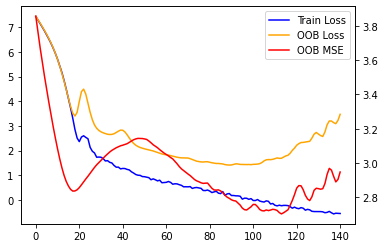

Bootstrap iteration 1 at time 2022-06-17 02:05:16.621773
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.832726955413818, MSE: 2.0120346546173096
Epoch: 0, Loss: 7.377204895019531, OOB Loss: 7.046712398529053, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9216177463531494, MSE: 1.725932002067566
Epoch: 40, Loss: 1.6186023950576782, OOB Loss: 0.8425168991088867, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.014583110809326, MSE: 1.626440405845642
Epoch: 80, Loss: 0.42960643768310547, OOB Loss: 0.7648341655731201, LR: 0.00040823971994699836
Early stopped, best epoch: 62, train loss: 0.7541708946228027, best OOB loss: 0.6111600399017334, LR: 0.00037587297488416934


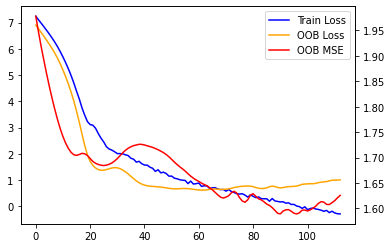

Bootstrap iteration 2 at time 2022-06-17 02:05:32.696162
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.601037979125977, MSE: 2.360989570617676
Epoch: 0, Loss: 7.173990249633789, OOB Loss: 6.929864883422852, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.986462116241455, MSE: 1.8766913414001465
Epoch: 40, Loss: 1.2924304008483887, OOB Loss: 0.9179039001464844, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.964163064956665, MSE: 1.9027951955795288
Epoch: 80, Loss: 0.33554601669311523, OOB Loss: 0.7523305416107178, LR: 0.00040823971994699836
Early stopped, best epoch: 52, train loss: 0.763298749923706, best OOB loss: 0.6663479804992676, LR: 0.0003854003082267038


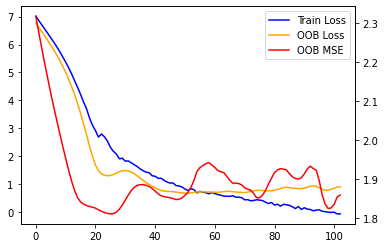

Bootstrap iteration 3 at time 2022-06-17 02:05:47.800562
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.476404666900635, MSE: 1.9519435167312622
Epoch: 0, Loss: 7.909924030303955, OOB Loss: 7.662192344665527, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.274712085723877, MSE: 1.5174446105957031
Epoch: 40, Loss: 1.4924533367156982, OOB Loss: 0.665554404258728, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.559361219406128, MSE: 1.4065850973129272
Epoch: 80, Loss: 0.3116791248321533, OOB Loss: 0.3646368980407715, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.450990676879883, MSE: 1.4223887920379639
Epoch: 120, Loss: -0.4772522449493408, OOB Loss: 0.5023758411407471, LR: 0.00036934432610923556
Early stopped, best epoch: 82, train loss: 0.25597238540649414, best OOB loss: 0.3598513603210449, LR: 0.00035751905063161196


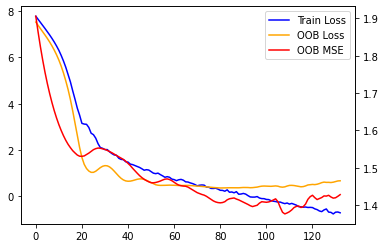

Bootstrap iteration 4 at time 2022-06-17 02:06:06.514884
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.460121154785156, MSE: 2.178095579147339
Epoch: 0, Loss: 7.947187423706055, OOB Loss: 7.639867305755615, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1198055744171143, MSE: 1.5898933410644531
Epoch: 40, Loss: 1.3467988967895508, OOB Loss: 0.8425590991973877, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.271770715713501, MSE: 1.5485906600952148
Epoch: 80, Loss: 0.15096616744995117, OOB Loss: 1.1300327777862549, LR: 0.00040823971994699836
Early stopped, best epoch: 38, train loss: 1.538478136062622, best OOB loss: 0.8155063390731812, LR: 0.00039914564637483674


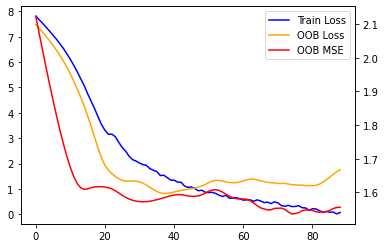

Bootstrap iteration 5 at time 2022-06-17 02:06:19.186963
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.747206687927246, MSE: 4.355447769165039
Epoch: 0, Loss: 8.139627456665039, OOB Loss: 8.084848403930664, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8586657047271729, MSE: 3.0055906772613525
Epoch: 40, Loss: 1.4353724718093872, OOB Loss: 2.5253632068634033, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.830584764480591, MSE: 2.7108914852142334
Epoch: 80, Loss: 0.33512210845947266, OOB Loss: 1.1081664562225342, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.633397102355957, MSE: 3.019129991531372
Epoch: 120, Loss: -0.30655908584594727, OOB Loss: 1.9286308288574219, LR: 0.00036934432610923556
Early stopped, best epoch: 93, train loss: 0.1796567440032959, best OOB loss: 1.0430917739868164, LR: 0.000347809256776649


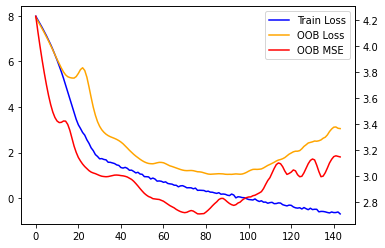

Bootstrap iteration 6 at time 2022-06-17 02:06:39.849969
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -8.031060218811035, MSE: 4.68728494644165
Epoch: 0, Loss: 8.396289825439453, OOB Loss: 8.361729621887207, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.393938660621643, MSE: 3.3295888900756836
Epoch: 40, Loss: 0.7956404685974121, OOB Loss: 3.6371169090270996, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.527713656425476, MSE: 3.8015666007995605
Epoch: 80, Loss: 0.009601831436157227, OOB Loss: 2.7342658042907715, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.1218602657318115, MSE: 3.7782466411590576
Epoch: 120, Loss: -0.883669376373291, OOB Loss: 2.979980230331421, LR: 0.00036934432610923556
Early stopped, best epoch: 91, train loss: -0.1748032569885254, best OOB loss: 2.628230094909668, LR: 0.00034955484629031123


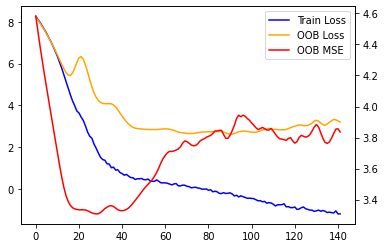

Bootstrap iteration 7 at time 2022-06-17 02:06:59.657498
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.438449382781982, MSE: 2.849653482437134
Epoch: 0, Loss: 7.889001846313477, OOB Loss: 7.678586959838867, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.80142080783844, MSE: 2.1509487628936768
Epoch: 40, Loss: 1.3682034015655518, OOB Loss: 1.9930399656295776, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3537609577178955, MSE: 2.336735963821411
Epoch: 80, Loss: 0.45861172676086426, OOB Loss: 1.0685985088348389, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.0185725688934326, MSE: 2.407601833343506
Epoch: 120, Loss: -0.27786827087402344, OOB Loss: 1.393970251083374, LR: 0.00036934432610923556
Early stopped, best epoch: 101, train loss: 0.18340468406677246, best OOB loss: 1.0019989013671875, LR: 0.00034091363487709353


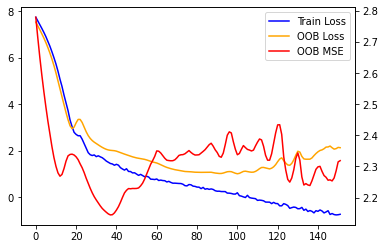

Bootstrap iteration 8 at time 2022-06-17 02:07:21.599985
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.074581623077393, MSE: 1.590180516242981
Epoch: 0, Loss: 7.644349098205566, OOB Loss: 7.233144283294678, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.4952781200408936, MSE: 1.2105369567871094
Epoch: 40, Loss: 1.5554624795913696, OOB Loss: -0.14753293991088867, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.3225319385528564, MSE: 1.2077136039733887
Epoch: 80, Loss: 0.7086400985717773, OOB Loss: -0.4730186462402344, LR: 0.00040823971994699836
Early stopped, best epoch: 87, train loss: 0.48282957077026367, best OOB loss: -0.5012280941009521, LR: 0.0004001460114033451


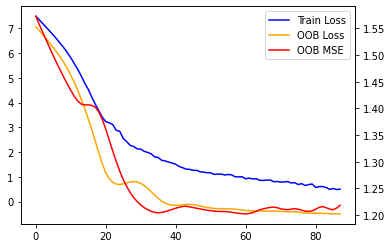

Bootstrap iteration 9 at time 2022-06-17 02:07:35.803136
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -8.074044227600098, MSE: 5.907992362976074
Epoch: 0, Loss: 8.399211883544922, OOB Loss: 8.560246467590332, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6642787456512451, MSE: 4.066501617431641
Epoch: 40, Loss: 0.9552328586578369, OOB Loss: 5.3956451416015625, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.7877435684204102, MSE: 3.997051239013672
Epoch: 80, Loss: 0.0390477180480957, OOB Loss: 3.113325595855713, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.5846457481384277, MSE: 4.304892063140869
Epoch: 120, Loss: -0.6978054046630859, OOB Loss: 4.789093971252441, LR: 0.00036934432610923556
Early stopped, best epoch: 74, train loss: 0.18643784523010254, best OOB loss: 2.942856788635254, LR: 0.0003656647101907795


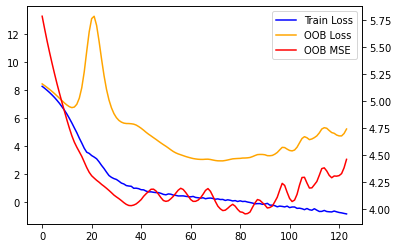

Bootstrap iteration 10 at time 2022-06-17 02:07:53.598608
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.463518142700195, MSE: 4.843122482299805
Epoch: 0, Loss: 7.779351234436035, OOB Loss: 7.916141986846924, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8527170419692993, MSE: 4.9079461097717285
Epoch: 40, Loss: 0.6323387622833252, OOB Loss: 8.425321578979492, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.7674838304519653, MSE: 4.490590572357178
Epoch: 80, Loss: -0.1499314308166504, OOB Loss: 3.951345443725586, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.5493080615997314, MSE: 4.231836318969727
Epoch: 120, Loss: -0.8446085453033447, OOB Loss: 4.759983062744141, LR: 0.00036934432610923556
Early stopped, best epoch: 89, train loss: -0.3265824317932129, best OOB loss: 3.7667675018310547, LR: 0.00035130919659078646


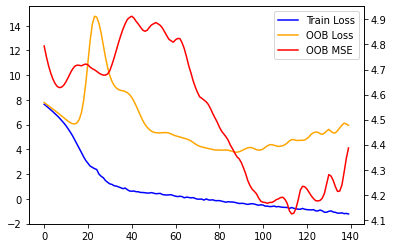

Bootstrap iteration 11 at time 2022-06-17 02:08:13.208851
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.821269512176514, MSE: 2.7147438526153564
Epoch: 0, Loss: 7.400134563446045, OOB Loss: 7.127434253692627, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.914079189300537, MSE: 1.9280375242233276
Epoch: 40, Loss: 1.532462239265442, OOB Loss: 1.1795248985290527, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.0764925479888916, MSE: 1.9969450235366821
Epoch: 80, Loss: 0.21176815032958984, OOB Loss: 1.113013505935669, LR: 0.00040823971994699836
Early stopped, best epoch: 52, train loss: 0.9491671323776245, best OOB loss: 1.029080867767334, LR: 0.0003854003082267038


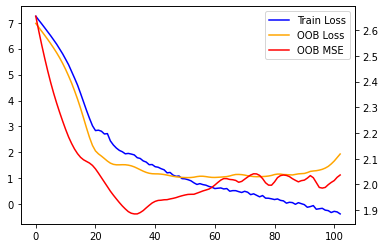

Bootstrap iteration 12 at time 2022-06-17 02:08:28.261128
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.790914058685303, MSE: 5.990804672241211
Epoch: 0, Loss: 8.116900444030762, OOB Loss: 8.215179443359375, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.192900538444519, MSE: 4.534243106842041
Epoch: 40, Loss: 0.6887335777282715, OOB Loss: 5.674121379852295, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.305513620376587, MSE: 4.38791561126709
Epoch: 80, Loss: -0.3770322799682617, OOB Loss: 5.102863311767578, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.74310564994812, MSE: 4.149096965789795
Epoch: 120, Loss: -1.1451871395111084, OOB Loss: 7.420503616333008, LR: 0.00036934432610923556
Early stopped, best epoch: 70, train loss: -0.17636609077453613, best OOB loss: 5.018870830535889, LR: 0.0003684209652939625


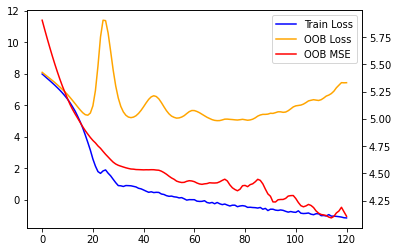

Bootstrap iteration 13 at time 2022-06-17 02:08:44.512535
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.843510150909424, MSE: 1.6052347421646118
Epoch: 0, Loss: 7.464066982269287, OOB Loss: 7.028888702392578, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8635624647140503, MSE: 1.337557077407837
Epoch: 40, Loss: 1.6959080696105957, OOB Loss: 0.4888061285018921, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9549126625061035, MSE: 1.3536417484283447
Epoch: 80, Loss: 0.33135509490966797, OOB Loss: 0.6245365142822266, LR: 0.00040823971994699836
Early stopped, best epoch: 51, train loss: 1.0794776678085327, best OOB loss: 0.333223819732666, LR: 0.0003863662237861692


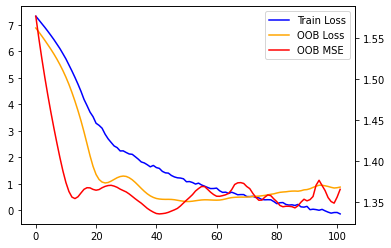

Bootstrap iteration 14 at time 2022-06-17 02:08:58.986678
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.347593307495117, MSE: 2.468231678009033
Epoch: 0, Loss: 7.829163551330566, OOB Loss: 7.588298320770264, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7310703992843628, MSE: 1.933671236038208
Epoch: 40, Loss: 1.1938843727111816, OOB Loss: 1.3015011548995972, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.465562582015991, MSE: 1.8160573244094849
Epoch: 80, Loss: 0.26170849800109863, OOB Loss: 0.8070979118347168, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.0265276432037354, MSE: 1.8413338661193848
Epoch: 120, Loss: -0.38098573684692383, OOB Loss: 1.000476598739624, LR: 0.00036934432610923556
Early stopped, best epoch: 84, train loss: 0.26020288467407227, best OOB loss: 0.7802145481109619, LR: 0.0003557336898725204


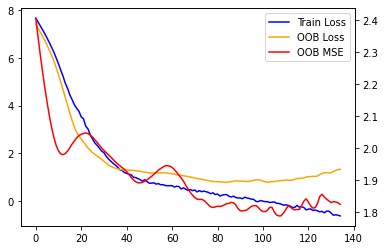

Bootstrap iteration 15 at time 2022-06-17 02:09:18.895128
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.093259334564209, MSE: 4.305062294006348
Epoch: 0, Loss: 7.540115833282471, OOB Loss: 7.519863128662109, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.889312982559204, MSE: 3.0456042289733887
Epoch: 40, Loss: 1.2208271026611328, OOB Loss: 2.420240640640259, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.0307416915893555, MSE: 3.885878324508667
Epoch: 80, Loss: 0.006561279296875, OOB Loss: 2.186889171600342, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.413543224334717, MSE: 4.257383823394775
Epoch: 120, Loss: -0.535585880279541, OOB Loss: 2.630641460418701, LR: 0.00036934432610923556
Early stopped, best epoch: 80, train loss: 0.006561279296875, best OOB loss: 2.186889171600342, LR: 0.00035931337178194805


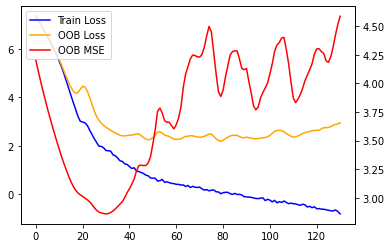

Bootstrap iteration 16 at time 2022-06-17 02:09:36.905618
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.427638053894043, MSE: 1.8682397603988647
Epoch: 0, Loss: 7.8977131843566895, OOB Loss: 7.5914177894592285, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1836891174316406, MSE: 1.352655053138733
Epoch: 40, Loss: 1.505270004272461, OOB Loss: 0.2709496021270752, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.021528482437134, MSE: 1.2745733261108398
Epoch: 80, Loss: 0.44553279876708984, OOB Loss: 0.01016688346862793, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.9647068977355957, MSE: 1.3433945178985596
Epoch: 120, Loss: -0.27397656440734863, OOB Loss: 0.31874704360961914, LR: 0.00036934432610923556
Early stopped, best epoch: 93, train loss: 0.2460343837738037, best OOB loss: -0.01434183120727539, LR: 0.0003521896707677057


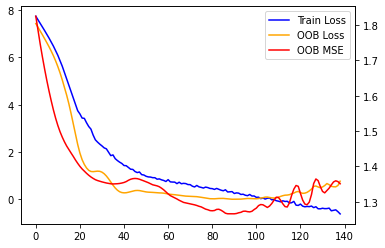

Bootstrap iteration 17 at time 2022-06-17 02:09:57.102175
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -8.151657104492188, MSE: 2.067499876022339
Epoch: 0, Loss: 8.508570671081543, OOB Loss: 8.29103946685791, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.5005619525909424, MSE: 1.7691682577133179
Epoch: 40, Loss: 1.4451582431793213, OOB Loss: 0.981609582901001, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.579259157180786, MSE: 1.7195188999176025
Epoch: 80, Loss: 0.20511126518249512, OOB Loss: 1.4372532367706299, LR: 0.00040823971994699836
Early stopped, best epoch: 47, train loss: 1.064225435256958, best OOB loss: 0.8224520683288574, LR: 0.00039025415518281834


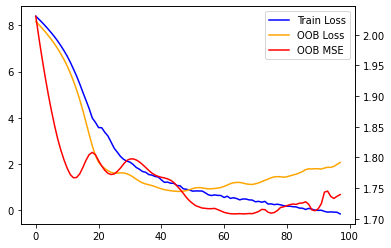

Bootstrap iteration 18 at time 2022-06-17 02:10:11.384889
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.018527030944824, MSE: 3.533823013305664
Epoch: 0, Loss: 7.516017913818359, OOB Loss: 7.429261684417725, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1153132915496826, MSE: 2.71834135055542
Epoch: 40, Loss: 1.215038776397705, OOB Loss: 2.0643928050994873, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.593060255050659, MSE: 2.7665066719055176
Epoch: 80, Loss: 0.1684119701385498, OOB Loss: 1.6275999546051025, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.0806007385253906, MSE: 2.813568592071533
Epoch: 120, Loss: -0.6014647483825684, OOB Loss: 2.294990062713623, LR: 0.00036934432610923556
Early stopped, best epoch: 82, train loss: 0.09728384017944336, best OOB loss: 1.5975985527038574, LR: 0.00035751905063161196


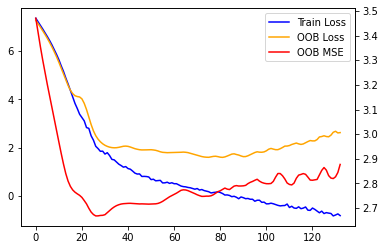

Bootstrap iteration 19 at time 2022-06-17 02:10:29.786331
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.993577003479004, MSE: 2.2133939266204834
Epoch: 0, Loss: 7.493776798248291, OOB Loss: 7.217518329620361, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9576085805892944, MSE: 1.7643258571624756
Epoch: 40, Loss: 1.325122356414795, OOB Loss: 0.8794690370559692, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.780275821685791, MSE: 1.666831374168396
Epoch: 80, Loss: 0.27718210220336914, OOB Loss: 0.762169599533081, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.334172487258911, MSE: 1.7447386980056763
Epoch: 120, Loss: -0.3965635299682617, OOB Loss: 1.1807963848114014, LR: 0.00036934432610923556
Early stopped, best epoch: 78, train loss: 0.30257439613342285, best OOB loss: 0.7515525817871094, LR: 0.00036111669829405396


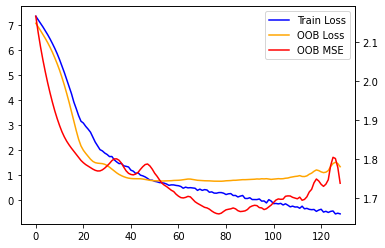

Bootstrap iteration 20 at time 2022-06-17 02:10:48.061384
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -8.454571723937988, MSE: 5.736128330230713
Epoch: 0, Loss: 8.755264282226562, OOB Loss: 8.812844276428223, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.468641519546509, MSE: 3.794461727142334
Epoch: 40, Loss: 1.31965970993042, OOB Loss: 5.029779434204102, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.6470589637756348, MSE: 4.321346282958984
Epoch: 80, Loss: 0.3200705051422119, OOB Loss: 2.7030887603759766, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.365679740905762, MSE: 4.858305931091309
Epoch: 120, Loss: -0.2469162940979004, OOB Loss: 4.422654151916504, LR: 0.00036934432610923556
Early stopped, best epoch: 73, train loss: 0.4491691589355469, best OOB loss: 2.502929925918579, LR: 0.0003656647101907795


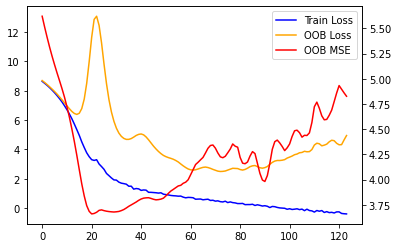

Bootstrap iteration 21 at time 2022-06-17 02:11:04.801702
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.241639614105225, MSE: 1.8408821821212769
Epoch: 0, Loss: 7.778789520263672, OOB Loss: 7.4117560386657715, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.543317198753357, MSE: 1.323752760887146
Epoch: 40, Loss: 1.5602279901504517, OOB Loss: 0.420385479927063, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.888230085372925, MSE: 1.2709439992904663
Epoch: 80, Loss: 0.4055962562561035, OOB Loss: 0.039469242095947266, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.720789670944214, MSE: 1.4110426902770996
Epoch: 120, Loss: -0.4804205894470215, OOB Loss: 0.30597758293151855, LR: 0.00036934432610923556
Early stopped, best epoch: 76, train loss: 0.5137844085693359, best OOB loss: -0.01410222053527832, LR: 0.0003656647101907795


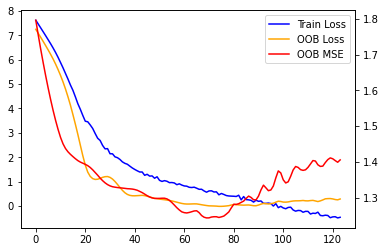

Bootstrap iteration 22 at time 2022-06-17 02:11:22.524527
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.5216851234436035, MSE: 1.5779582262039185
Epoch: 0, Loss: 7.991517066955566, OOB Loss: 7.658267498016357, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.480120897293091, MSE: 1.228029727935791
Epoch: 40, Loss: 1.5060478448867798, OOB Loss: 0.2456066608428955, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9947659969329834, MSE: 1.204210877418518
Epoch: 80, Loss: 0.3330082893371582, OOB Loss: 0.2658987045288086, LR: 0.00040823971994699836
Early stopped, best epoch: 68, train loss: 0.5044195652008057, best OOB loss: 0.10947489738464355, LR: 0.00037027000111201555


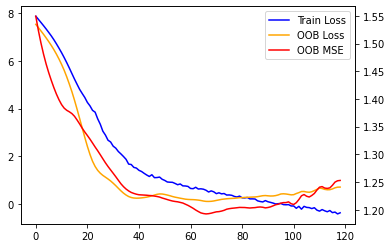

Bootstrap iteration 23 at time 2022-06-17 02:11:39.369465
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.11167573928833, MSE: 2.298794984817505
Epoch: 0, Loss: 7.656469821929932, OOB Loss: 7.361810684204102, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.492746114730835, MSE: 1.5630470514297485
Epoch: 40, Loss: 1.6013010740280151, OOB Loss: 1.0562703609466553, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.5755794048309326, MSE: 1.5493017435073853
Epoch: 80, Loss: 0.6808252334594727, OOB Loss: -0.09752821922302246, LR: 0.00040823971994699836
Early stopped, best epoch: 89, train loss: 0.5797815322875977, best OOB loss: -0.22099900245666504, LR: 0.0003721283168945075


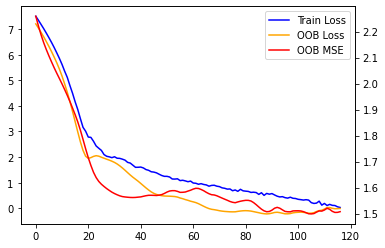

Bootstrap iteration 24 at time 2022-06-17 02:11:56.768683
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.795155048370361, MSE: 2.8285603523254395
Epoch: 0, Loss: 7.336683750152588, OOB Loss: 7.1655402183532715, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.0302438735961914, MSE: 2.175846576690674
Epoch: 40, Loss: 1.292419195175171, OOB Loss: 2.801394462585449, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.996445655822754, MSE: 2.2594082355499268
Epoch: 80, Loss: 0.20061087608337402, OOB Loss: 2.8175835609436035, LR: 0.00040823971994699836
Early stopped, best epoch: 47, train loss: 1.0554640293121338, best OOB loss: 2.1239383220672607, LR: 0.00039025415518281834


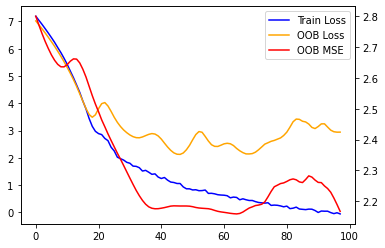

Time 0, 2022-06-17 02:12:10.572338
Time 5, 2022-06-17 02:27:57.995035
Time 10, 2022-06-17 02:43:33.024189
Time 15, 2022-06-17 02:59:05.798785
Time 20, 2022-06-17 03:14:36.606882
Time 25, 2022-06-17 03:30:04.214889
Time 30, 2022-06-17 03:45:27.484395
Time 35, 2022-06-17 04:00:48.044849
Time 40, 2022-06-17 04:16:07.612660
Time 45, 2022-06-17 04:31:43.833831
Time 50, 2022-06-17 04:47:19.673042
Time 55, 2022-06-17 05:02:49.534213
Time 60, 2022-06-17 05:18:20.418422
Time 65, 2022-06-17 05:33:47.588273
Time 70, 2022-06-17 05:49:16.487937
Time 75, 2022-06-17 06:04:44.742163
Time 80, 2022-06-17 06:20:22.348241
Time 85, 2022-06-17 06:36:02.648884
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (641, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Epoch: 0, Loss: 0.7982356548309326, OOB Loss: 1.0328669548034668
Epoch: 40, Loss: 0.5579859614372253, OOB Loss: 0.9066919088363647
Early stopped, best epoch: 27, train loss: 0.5934420824050903, best OOB loss: 0.8855897784233093, LR: 0.00041028859863643906


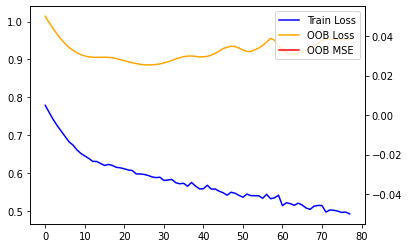

Bootstrap iteration 1 at time 2022-06-17 06:51:59.062227
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0624010562896729, OOB Loss: 0.5124620199203491
Epoch: 40, Loss: 0.7102445363998413, OOB Loss: 0.37754353880882263
Epoch: 80, Loss: 0.6089527606964111, OOB Loss: 0.3593449592590332
Epoch: 120, Loss: 0.4713793694972992, OOB Loss: 0.37902897596359253
Early stopped, best epoch: 72, train loss: 0.6302831172943115, best OOB loss: 0.3589489161968231, LR: 0.0003665811630985258


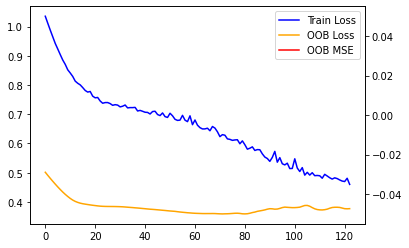

Bootstrap iteration 2 at time 2022-06-17 06:52:31.367688
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.6843065619468689, OOB Loss: 1.5455350875854492
Epoch: 40, Loss: 0.5044686794281006, OOB Loss: 1.2719054222106934
Early stopped, best epoch: 24, train loss: 0.5223602056503296, best OOB loss: 1.2485952377319336, LR: 0.0004133812132975024


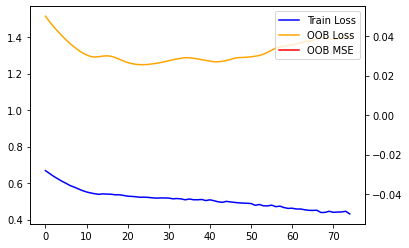

Bootstrap iteration 3 at time 2022-06-17 06:52:50.662851
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1332321166992188, OOB Loss: 0.5566605925559998
Epoch: 40, Loss: 0.7220849394798279, OOB Loss: 0.37957367300987244
Epoch: 80, Loss: 0.6275014281272888, OOB Loss: 0.35333943367004395
Epoch: 120, Loss: 0.4984669089317322, OOB Loss: 0.35926222801208496
Early stopped, best epoch: 89, train loss: 0.5853127241134644, best OOB loss: 0.35155653953552246, LR: 0.00035130919659078646


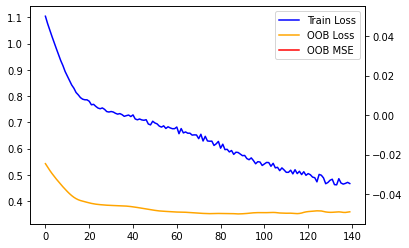

Bootstrap iteration 4 at time 2022-06-17 06:53:27.421427
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.097069263458252, OOB Loss: 0.9533466100692749
Epoch: 40, Loss: 0.6749951839447021, OOB Loss: 0.5394726991653442
Epoch: 80, Loss: 0.585949182510376, OOB Loss: 0.4760302007198334
Epoch: 120, Loss: 0.503227710723877, OOB Loss: 0.49275004863739014
Early stopped, best epoch: 103, train loss: 0.5112188458442688, best OOB loss: 0.47279807925224304, LR: 0.0003392111974129261


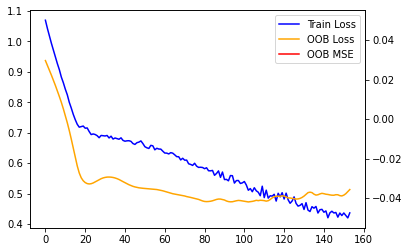

Bootstrap iteration 5 at time 2022-06-17 06:54:06.764154
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.863917350769043, OOB Loss: 1.3183996677398682
Epoch: 40, Loss: 0.5609549283981323, OOB Loss: 0.9607890844345093
Early stopped, best epoch: 28, train loss: 0.5799475312232971, best OOB loss: 0.942369818687439, LR: 0.000409262877139848


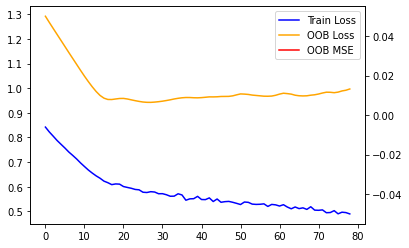

Bootstrap iteration 6 at time 2022-06-17 06:54:26.985485
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9389505386352539, OOB Loss: 1.1856153011322021
Epoch: 40, Loss: 0.5885549783706665, OOB Loss: 0.8642451763153076
Early stopped, best epoch: 26, train loss: 0.6103497743606567, best OOB loss: 0.85791015625, LR: 0.00041234776026425864


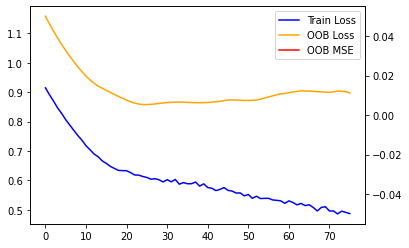

Bootstrap iteration 7 at time 2022-06-17 06:54:46.601062
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9098650813102722, OOB Loss: 0.6725897192955017
Epoch: 40, Loss: 0.6645657420158386, OOB Loss: 0.5881044864654541
Epoch: 80, Loss: 0.5311238765716553, OOB Loss: 0.5739244222640991
Early stopped, best epoch: 55, train loss: 0.6124553680419922, best OOB loss: 0.5720765590667725, LR: 0.000382517026148903


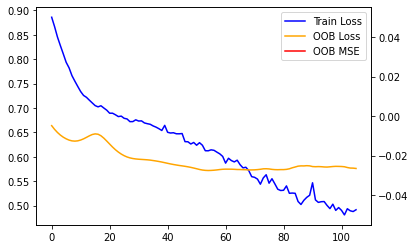

Bootstrap iteration 8 at time 2022-06-17 06:55:14.428793
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0111547708511353, OOB Loss: 0.4538561701774597
Epoch: 40, Loss: 0.7055432200431824, OOB Loss: 0.4031848907470703
Epoch: 80, Loss: 0.5748605728149414, OOB Loss: 0.3985041081905365
Epoch: 120, Loss: 0.48811620473861694, OOB Loss: 0.41628870368003845
Early stopped, best epoch: 71, train loss: 0.5994061827659607, best OOB loss: 0.3981080949306488, LR: 0.0003674999128807276


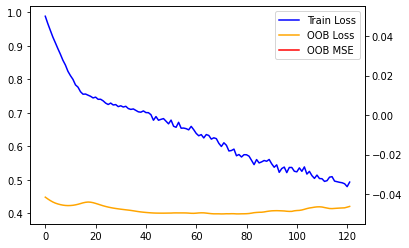

Bootstrap iteration 9 at time 2022-06-17 06:55:45.535013
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9789931178092957, OOB Loss: 0.7119113802909851
Epoch: 40, Loss: 0.6786916255950928, OOB Loss: 0.5420309901237488
Early stopped, best epoch: 15, train loss: 0.7278156280517578, best OOB loss: 0.5253233313560486, LR: 0.0004227996278567497


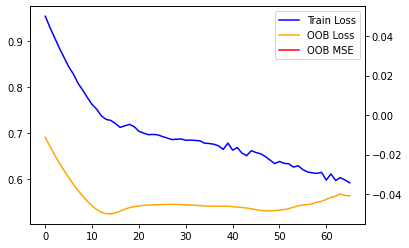

Bootstrap iteration 10 at time 2022-06-17 06:56:02.520852
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1083546876907349, OOB Loss: 0.4651010036468506
Epoch: 40, Loss: 0.7099310755729675, OOB Loss: 0.37480729818344116
Epoch: 80, Loss: 0.6166418790817261, OOB Loss: 0.34589678049087524
Epoch: 120, Loss: 0.5426557660102844, OOB Loss: 0.35114023089408875
Early stopped, best epoch: 96, train loss: 0.5925711393356323, best OOB loss: 0.34218811988830566, LR: 0.0003452072033398691


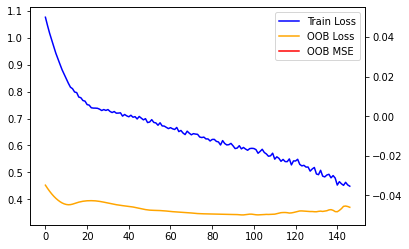

Bootstrap iteration 11 at time 2022-06-17 06:56:40.330653
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8635775446891785, OOB Loss: 1.318580150604248
Epoch: 40, Loss: 0.5824037194252014, OOB Loss: 0.8814279437065125
Epoch: 80, Loss: 0.5080380439758301, OOB Loss: 0.8474463224411011
Epoch: 120, Loss: 0.42556434869766235, OOB Loss: 1.0251049995422363
Early stopped, best epoch: 69, train loss: 0.5371593236923218, best OOB loss: 0.8384032249450684, LR: 0.00036934432610923556


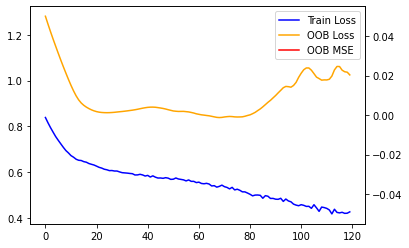

Bootstrap iteration 12 at time 2022-06-17 06:57:10.850824
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.104001760482788, OOB Loss: 0.4353533685207367
Epoch: 40, Loss: 0.7172001600265503, OOB Loss: 0.3821077048778534
Epoch: 80, Loss: 0.6043063998222351, OOB Loss: 0.36426493525505066
Epoch: 120, Loss: 0.5082566738128662, OOB Loss: 0.39744871854782104
Early stopped, best epoch: 78, train loss: 0.6152185201644897, best OOB loss: 0.36352550983428955, LR: 0.00036111669829405396


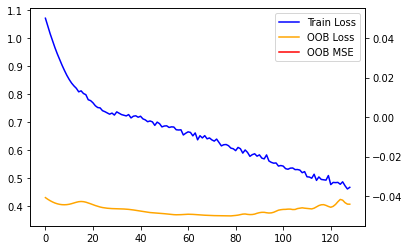

Bootstrap iteration 13 at time 2022-06-17 06:57:44.022923
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.072796106338501, OOB Loss: 0.6502658724784851
Epoch: 40, Loss: 0.6752240061759949, OOB Loss: 0.557874858379364
Early stopped, best epoch: 14, train loss: 0.7564328908920288, best OOB loss: 0.5292565822601318, LR: 0.0004238592760468668


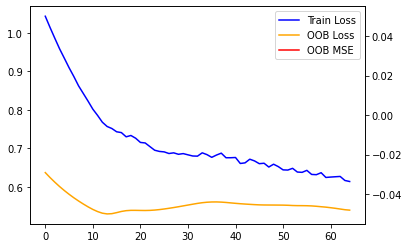

Bootstrap iteration 14 at time 2022-06-17 06:58:00.779826
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0580120086669922, OOB Loss: 0.42962583899497986
Epoch: 40, Loss: 0.7153301239013672, OOB Loss: 0.41694626212120056
Epoch: 80, Loss: 0.5966638922691345, OOB Loss: 0.3681759834289551
Epoch: 120, Loss: 0.5003076791763306, OOB Loss: 0.355089008808136
Epoch: 160, Loss: 0.4265786111354828, OOB Loss: 0.3419186472892761
Epoch: 200, Loss: 0.3742583990097046, OOB Loss: 0.359729528427124
Early stopped, best epoch: 159, train loss: 0.43481358885765076, best OOB loss: 0.34139037132263184, LR: 0.0002948443595594986


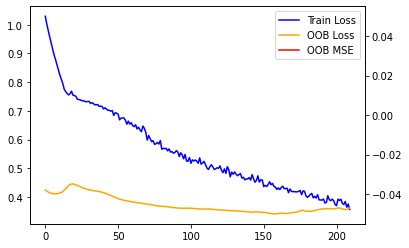

Bootstrap iteration 15 at time 2022-06-17 06:58:55.095800
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0901975631713867, OOB Loss: 0.38449323177337646
Epoch: 40, Loss: 0.7366623878479004, OOB Loss: 0.3384387493133545
Epoch: 80, Loss: 0.6414239406585693, OOB Loss: 0.32031404972076416
Epoch: 120, Loss: 0.5503348112106323, OOB Loss: 0.3189878463745117
Epoch: 160, Loss: 0.4365695118904114, OOB Loss: 0.32135242223739624
Early stopped, best epoch: 110, train loss: 0.5764967203140259, best OOB loss: 0.31222450733184814, LR: 0.00033331933788480705


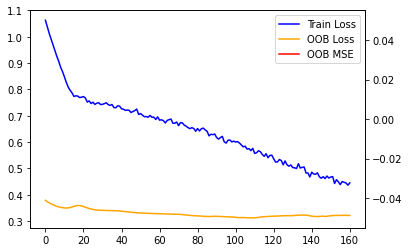

Bootstrap iteration 16 at time 2022-06-17 06:59:37.243392
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0011157989501953, OOB Loss: 0.6434518694877625
Epoch: 40, Loss: 0.6750028133392334, OOB Loss: 0.46537765860557556
Epoch: 80, Loss: 0.5807216167449951, OOB Loss: 0.5597858428955078
Early stopped, best epoch: 47, train loss: 0.6510103940963745, best OOB loss: 0.4582328200340271, LR: 0.00039025415518281834


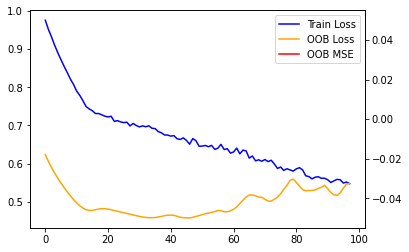

Bootstrap iteration 17 at time 2022-06-17 07:00:02.406895
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0427254438400269, OOB Loss: 0.6453551054000854
Epoch: 40, Loss: 0.6700496077537537, OOB Loss: 0.5909661054611206
Epoch: 80, Loss: 0.5797244310379028, OOB Loss: 0.5765254497528076
Epoch: 120, Loss: 0.4691968858242035, OOB Loss: 0.6337745189666748
Early stopped, best epoch: 75, train loss: 0.599564254283905, best OOB loss: 0.574263334274292, LR: 0.0003638386720442643


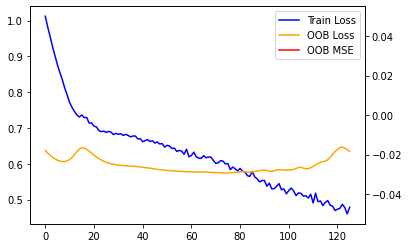

Bootstrap iteration 18 at time 2022-06-17 07:00:34.935227
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.6455168724060059, OOB Loss: 2.192770481109619
Epoch: 40, Loss: 0.4716913104057312, OOB Loss: 1.4369208812713623
Epoch: 80, Loss: 0.41147980093955994, OOB Loss: 1.547943115234375
Early stopped, best epoch: 38, train loss: 0.46795856952667236, best OOB loss: 1.4357327222824097, LR: 0.00039914564637483674


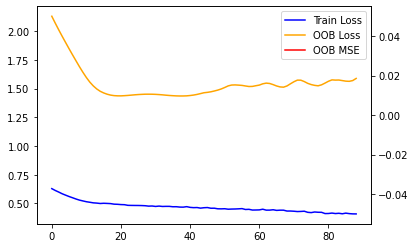

Bootstrap iteration 19 at time 2022-06-17 07:00:57.819991
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0236477851867676, OOB Loss: 0.7638022303581238
Epoch: 40, Loss: 0.6619411706924438, OOB Loss: 0.5601350665092468
Epoch: 80, Loss: 0.5700631141662598, OOB Loss: 0.6027435660362244
Early stopped, best epoch: 44, train loss: 0.6460708975791931, best OOB loss: 0.5578123927116394, LR: 0.0003931957570841881


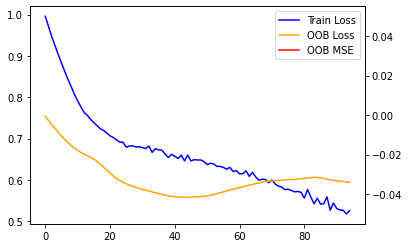

Bootstrap iteration 20 at time 2022-06-17 07:01:22.716108
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.874175488948822, OOB Loss: 0.5811231136322021
Epoch: 40, Loss: 0.6579504013061523, OOB Loss: 0.5613481998443604
Epoch: 80, Loss: 0.5384602546691895, OOB Loss: 0.5491294860839844
Early stopped, best epoch: 67, train loss: 0.576385498046875, best OOB loss: 0.5401332974433899, LR: 0.00037119799610227123


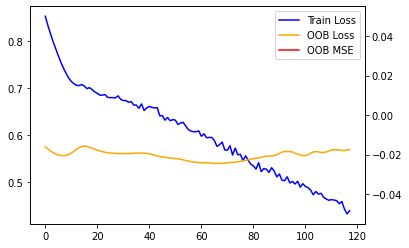

Bootstrap iteration 21 at time 2022-06-17 07:01:52.785887
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1406373977661133, OOB Loss: 0.6922404170036316
Epoch: 40, Loss: 0.69017493724823, OOB Loss: 0.41239863634109497
Epoch: 80, Loss: 0.6150211095809937, OOB Loss: 0.3924495577812195
Epoch: 120, Loss: 0.5084707140922546, OOB Loss: 0.38879716396331787
Epoch: 160, Loss: 0.44476407766342163, OOB Loss: 0.39280885457992554
Early stopped, best epoch: 124, train loss: 0.5083121657371521, best OOB loss: 0.3852154612541199, LR: 0.0003218408536469109


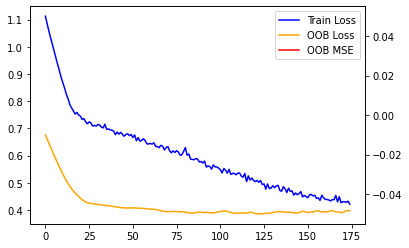

Bootstrap iteration 22 at time 2022-06-17 07:02:38.300824
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9274444580078125, OOB Loss: 0.956471860408783
Epoch: 40, Loss: 0.6369921565055847, OOB Loss: 0.6558210849761963
Epoch: 80, Loss: 0.52012038230896, OOB Loss: 0.6561686992645264
Early stopped, best epoch: 65, train loss: 0.5634424090385437, best OOB loss: 0.6368178129196167, LR: 0.00037306096931780195


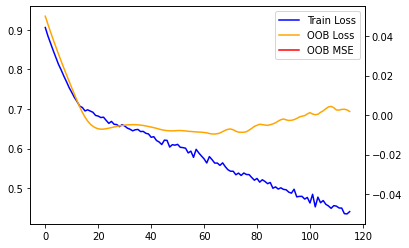

Bootstrap iteration 23 at time 2022-06-17 07:03:07.905668
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.2060918807983398, OOB Loss: 0.76233971118927
Epoch: 40, Loss: 0.6557105779647827, OOB Loss: 0.5819295644760132
Epoch: 80, Loss: 0.5712546706199646, OOB Loss: 0.5743231773376465
Epoch: 120, Loss: 0.45458316802978516, OOB Loss: 0.5887386798858643
Early stopped, best epoch: 82, train loss: 0.5661320090293884, best OOB loss: 0.5713380575180054, LR: 0.00035751905063161196


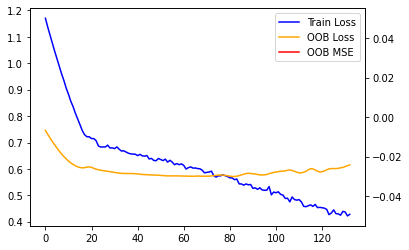

Bootstrap iteration 24 at time 2022-06-17 07:03:42.151996
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9796661138534546, OOB Loss: 0.8870746493339539
Epoch: 40, Loss: 0.6711146235466003, OOB Loss: 0.5425945520401001
Early stopped, best epoch: 24, train loss: 0.7034313678741455, best OOB loss: 0.514032244682312, LR: 0.00041441725643859886


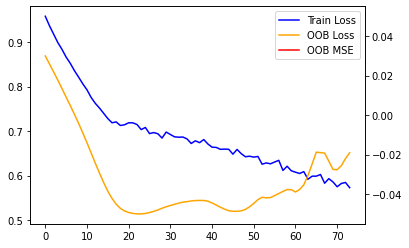

Time 0, 2022-06-17 07:04:01.338808
Time 5, 2022-06-17 07:19:41.524551
Time 10, 2022-06-17 07:35:10.533051
Time 15, 2022-06-17 07:50:38.911090
Time 20, 2022-06-17 08:06:05.267546
Time 25, 2022-06-17 08:21:33.130180
Time 30, 2022-06-17 08:36:58.560334
Time 35, 2022-06-17 08:52:51.241926
Time 40, 2022-06-17 09:08:53.048779
Time 45, 2022-06-17 09:24:54.188827
Time 50, 2022-06-17 09:40:44.139516
Time 55, 2022-06-17 09:56:47.437135
Time 60, 2022-06-17 10:12:49.262833
Time 65, 2022-06-17 10:28:32.184251
Time 70, 2022-06-17 10:44:13.839374
Time 75, 2022-06-17 10:59:56.214126
Time 80, 2022-06-17 11:15:47.100934
Time 85, 2022-06-17 11:31:27.591435
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (641, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


OOB Mean Log Det Precision: -7.204449653625488, MSE: 5.43686056137085
Epoch: 0, Loss: 7.607392311096191, OOB Loss: 7.675450801849365, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9664355516433716, MSE: 4.160519599914551
Epoch: 40, Loss: 0.9683423042297363, OOB Loss: 4.2956624031066895, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.358686923980713, MSE: 4.082584857940674
Epoch: 80, Loss: -0.0309600830078125, OOB Loss: 2.2637434005737305, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.2001426219940186, MSE: 4.842129230499268
Epoch: 120, Loss: -0.5119547843933105, OOB Loss: 3.78483510017395, LR: 0.00036934432610923556
Early stopped, best epoch: 69, train loss: 0.2069997787475586, best OOB loss: 1.9951245784759521, LR: 0.00036934432610923556


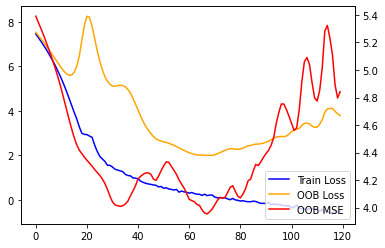

Bootstrap iteration 1 at time 2022-06-17 11:47:41.141025
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.949724197387695, MSE: 4.048439979553223
Epoch: 0, Loss: 7.433668613433838, OOB Loss: 7.308424472808838, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.123647689819336, MSE: 2.7114269733428955
Epoch: 40, Loss: 1.3437697887420654, OOB Loss: 1.6163556575775146, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.8040413856506348, MSE: 2.878013849258423
Epoch: 80, Loss: 0.24236202239990234, OOB Loss: 1.2511014938354492, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.969766616821289, MSE: 2.962810754776001
Epoch: 120, Loss: -0.4613926410675049, OOB Loss: 2.8530240058898926, LR: 0.00036934432610923556
Early stopped, best epoch: 70, train loss: 0.3905446529388428, best OOB loss: 1.2156774997711182, LR: 0.0003684209652939625


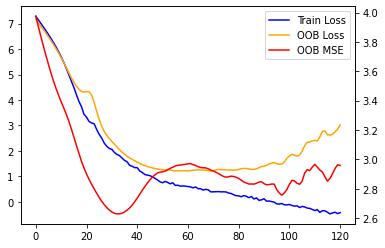

Bootstrap iteration 2 at time 2022-06-17 11:47:58.869835
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -8.097111701965332, MSE: 5.723690986633301
Epoch: 0, Loss: 8.427956581115723, OOB Loss: 8.482728958129883, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8997946977615356, MSE: 4.084733009338379
Epoch: 40, Loss: 0.7437851428985596, OOB Loss: 5.358667373657227, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.887900710105896, MSE: 4.1884846687316895
Epoch: 80, Loss: -0.09403872489929199, OOB Loss: 4.200212001800537, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.354886054992676, MSE: 4.494783878326416
Epoch: 120, Loss: -0.7100386619567871, OOB Loss: 5.315049648284912, LR: 0.00036934432610923556
Early stopped, best epoch: 70, train loss: 0.01614665985107422, best OOB loss: 3.961030960083008, LR: 0.0003684209652939625


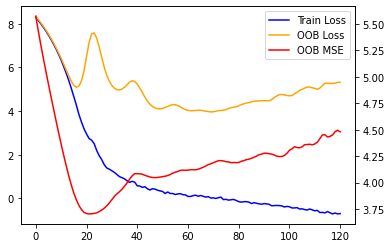

Bootstrap iteration 3 at time 2022-06-17 11:48:15.400882
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.700163841247559, MSE: 1.634338617324829
Epoch: 0, Loss: 8.17146110534668, OOB Loss: 7.827493190765381, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7807918787002563, MSE: 1.3637315034866333
Epoch: 40, Loss: 1.5543272495269775, OOB Loss: 0.1740959882736206, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.243293046951294, MSE: 1.3224157094955444
Epoch: 80, Loss: 0.47447896003723145, OOB Loss: -0.1926872730255127, LR: 0.00040823971994699836
Early stopped, best epoch: 83, train loss: 0.5055911540985107, best OOB loss: -0.22344279289245605, LR: 0.00039123223577224893


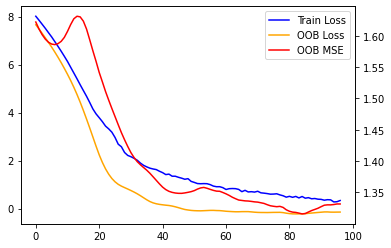

Bootstrap iteration 4 at time 2022-06-17 11:48:30.403414
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.2223968505859375, MSE: 2.222852945327759
Epoch: 0, Loss: 7.687328338623047, OOB Loss: 7.433557033538818, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6627339124679565, MSE: 1.8213865756988525
Epoch: 40, Loss: 1.1125783920288086, OOB Loss: 1.163781762123108, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.3567380905151367, MSE: 1.687503457069397
Epoch: 80, Loss: -0.08023548126220703, OOB Loss: 1.310614824295044, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.075253486633301, MSE: 1.7078982591629028
Epoch: 120, Loss: -0.7608141899108887, OOB Loss: 1.688786506652832, LR: 0.00036934432610923556
Early stopped, best epoch: 69, train loss: 0.1219942569732666, best OOB loss: 1.1084353923797607, LR: 0.00036934432610923556


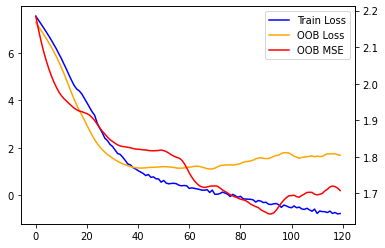

Bootstrap iteration 5 at time 2022-06-17 11:48:47.349423
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.754846572875977, MSE: 2.1633639335632324
Epoch: 0, Loss: 8.199536323547363, OOB Loss: 7.917300701141357, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6148124933242798, MSE: 1.4859559535980225
Epoch: 40, Loss: 1.796026349067688, OOB Loss: 0.6280075311660767, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9830074310302734, MSE: 1.3552364110946655
Epoch: 80, Loss: 0.5214180946350098, OOB Loss: 0.1687018871307373, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.62888503074646, MSE: 1.4678317308425903
Epoch: 120, Loss: -0.36724257469177246, OOB Loss: 0.6829783916473389, LR: 0.00036934432610923556
Early stopped, best epoch: 74, train loss: 0.6579742431640625, best OOB loss: 0.08917474746704102, LR: 0.00036475054841530254


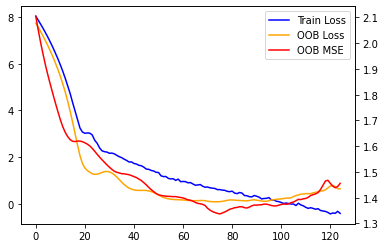

Bootstrap iteration 6 at time 2022-06-17 11:49:05.629288
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.881875038146973, MSE: 4.645843982696533
Epoch: 0, Loss: 8.258805274963379, OOB Loss: 8.268190383911133, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.088468313217163, MSE: 3.6693599224090576
Epoch: 40, Loss: 0.8232104778289795, OOB Loss: 5.095737457275391, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.9810984134674072, MSE: 3.660456895828247
Epoch: 80, Loss: -0.03709673881530762, OOB Loss: 3.013739824295044, LR: 0.00040823971994699836
Early stopped, best epoch: 63, train loss: 0.26316380500793457, best OOB loss: 2.8687915802001953, LR: 0.00037493329244695894


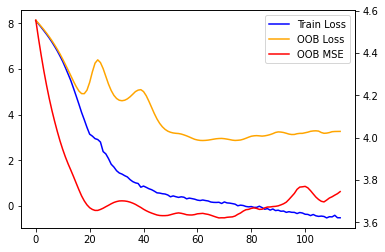

Bootstrap iteration 7 at time 2022-06-17 11:49:21.750322
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.979804515838623, MSE: 1.9965503215789795
Epoch: 0, Loss: 7.522727012634277, OOB Loss: 7.175690650939941, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 3.1441054344177246, MSE: 1.6940523386001587
Epoch: 40, Loss: 1.4294406175613403, OOB Loss: 0.7437927722930908, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9802002906799316, MSE: 1.6184417009353638
Epoch: 80, Loss: 0.61427903175354, OOB Loss: 0.25105714797973633, LR: 0.00040823971994699836
Early stopped, best epoch: 61, train loss: 0.890516996383667, best OOB loss: 0.11492085456848145, LR: 0.00037681501241520733


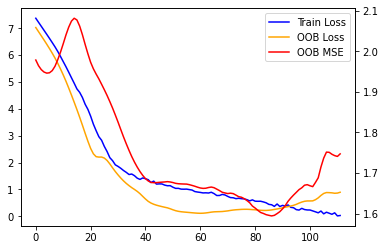

Bootstrap iteration 8 at time 2022-06-17 11:49:38.365517
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.589602947235107, MSE: 2.7775228023529053
Epoch: 0, Loss: 8.042426109313965, OOB Loss: 7.834676265716553, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.1460764408111572, MSE: 1.8371150493621826
Epoch: 40, Loss: 1.541129231452942, OOB Loss: 0.9552187919616699, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.309983968734741, MSE: 1.9288543462753296
Epoch: 80, Loss: 0.38341712951660156, OOB Loss: 0.5954413414001465, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.410256862640381, MSE: 1.9732460975646973
Epoch: 120, Loss: -0.2734348773956299, OOB Loss: 1.6199517250061035, LR: 0.00036934432610923556
Early stopped, best epoch: 74, train loss: 0.5070409774780273, best OOB loss: 0.5169284343719482, LR: 0.00036475054841530254


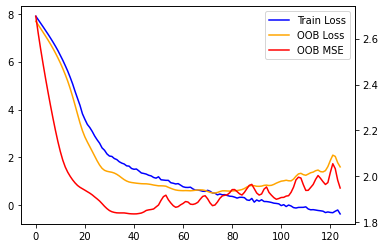

Bootstrap iteration 9 at time 2022-06-17 11:49:57.029144
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.450512409210205, MSE: 2.3507297039031982
Epoch: 0, Loss: 7.922560691833496, OOB Loss: 7.688973426818848, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.5732296705245972, MSE: 1.9343382120132446
Epoch: 40, Loss: 1.2098429203033447, OOB Loss: 0.9978560209274292, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.890442371368408, MSE: 2.079486608505249
Epoch: 80, Loss: 0.17395997047424316, OOB Loss: 0.8797051906585693, LR: 0.00040823971994699836
Early stopped, best epoch: 63, train loss: 0.483151912689209, best OOB loss: 0.6969420909881592, LR: 0.00037493329244695894


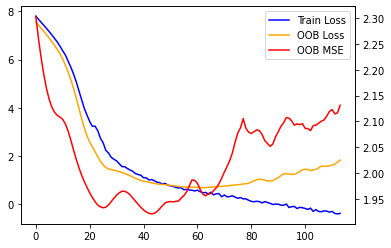

Bootstrap iteration 10 at time 2022-06-17 11:50:14.022394
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.423066139221191, MSE: 5.072200298309326
Epoch: 0, Loss: 7.824804306030273, OOB Loss: 7.823215961456299, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.104353666305542, MSE: 4.193784236907959
Epoch: 40, Loss: 0.9263722896575928, OOB Loss: 5.852556228637695, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.1575727462768555, MSE: 4.771576881408691
Epoch: 80, Loss: 0.04574251174926758, OOB Loss: 3.049962043762207, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.1460695266723633, MSE: 5.672338008880615
Epoch: 120, Loss: -0.5303006172180176, OOB Loss: 5.651354789733887, LR: 0.00036934432610923556
Early stopped, best epoch: 74, train loss: 0.11710262298583984, best OOB loss: 2.8037219047546387, LR: 0.00036475054841530254


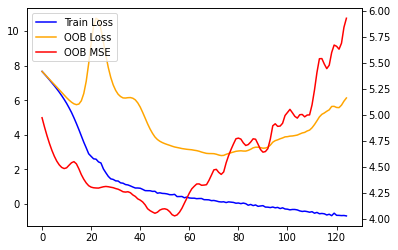

Bootstrap iteration 11 at time 2022-06-17 11:50:31.875240
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.658215045928955, MSE: 2.8078057765960693
Epoch: 0, Loss: 8.093629837036133, OOB Loss: 7.8789544105529785, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6846718788146973, MSE: 1.9220994710922241
Epoch: 40, Loss: 1.2085380554199219, OOB Loss: 0.9477357864379883, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 1.9757423400878906, MSE: 1.953216552734375
Epoch: 80, Loss: 0.23671245574951172, OOB Loss: 1.0712521076202393, LR: 0.00040823971994699836
Early stopped, best epoch: 38, train loss: 1.2936797142028809, best OOB loss: 0.940509557723999, LR: 0.00039914564637483674


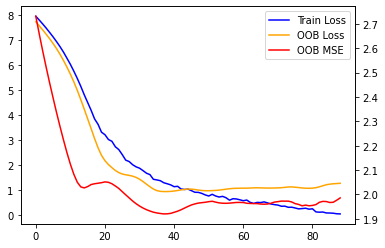

Bootstrap iteration 12 at time 2022-06-17 11:50:44.837750
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.095629692077637, MSE: 1.7111091613769531
Epoch: 0, Loss: 7.707229137420654, OOB Loss: 7.270902156829834, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.6236814260482788, MSE: 1.3671090602874756
Epoch: 40, Loss: 1.7663863897323608, OOB Loss: 0.5287889242172241, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.247473955154419, MSE: 1.2694674730300903
Epoch: 80, Loss: 0.5085654258728027, OOB Loss: 0.3114809989929199, LR: 0.00040823971994699836
Early stopped, best epoch: 54, train loss: 1.027930498123169, best OOB loss: 0.22621774673461914, LR: 0.0003834757154374967


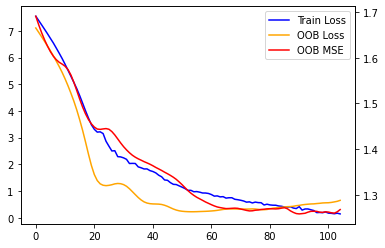

Bootstrap iteration 13 at time 2022-06-17 11:51:00.089651
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.1243977546691895, MSE: 4.601381301879883
Epoch: 0, Loss: 7.628268241882324, OOB Loss: 7.642595291137695, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.232407808303833, MSE: 2.5129337310791016
Epoch: 40, Loss: 1.3557440042495728, OOB Loss: 1.6520373821258545, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9259777069091797, MSE: 2.455035924911499
Epoch: 80, Loss: 0.22977757453918457, OOB Loss: 0.8238792419433594, LR: 0.00040823971994699836
Early stopped, best epoch: 67, train loss: 0.4137306213378906, best OOB loss: 0.7501840591430664, LR: 0.00037119799610227123


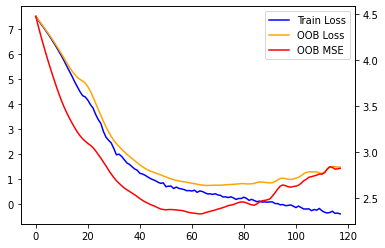

Bootstrap iteration 14 at time 2022-06-17 11:51:18.020924
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.241961479187012, MSE: 1.7467654943466187
Epoch: 0, Loss: 7.725915431976318, OOB Loss: 7.407734394073486, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.2193655967712402, MSE: 1.5415215492248535
Epoch: 40, Loss: 1.6917898654937744, OOB Loss: 0.724329948425293, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.6517436504364014, MSE: 1.4753272533416748
Epoch: 80, Loss: 0.5223329067230225, OOB Loss: 0.1790921688079834, LR: 0.00040823971994699836
Early stopped, best epoch: 63, train loss: 0.9166369438171387, best OOB loss: 0.15462660789489746, LR: 0.00037493329244695894


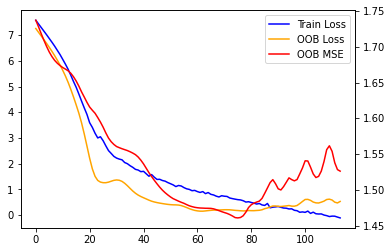

Bootstrap iteration 15 at time 2022-06-17 11:51:34.669026
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.842626094818115, MSE: 2.3531157970428467
Epoch: 0, Loss: 7.397293567657471, OOB Loss: 7.097185134887695, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.37357234954834, MSE: 1.7829407453536987
Epoch: 40, Loss: 1.4291070699691772, OOB Loss: 1.342081069946289, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.736572742462158, MSE: 1.774341106414795
Epoch: 80, Loss: 0.4103868007659912, OOB Loss: 0.6149182319641113, LR: 0.00040823971994699836
Early stopped, best epoch: 68, train loss: 0.7524635791778564, best OOB loss: 0.37901902198791504, LR: 0.00037027000111201555


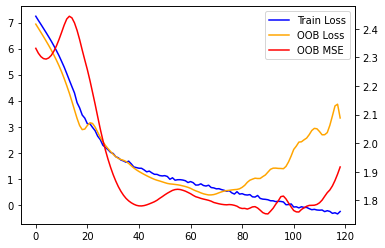

Bootstrap iteration 16 at time 2022-06-17 11:51:52.396852
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -6.949896335601807, MSE: 2.3007609844207764
Epoch: 0, Loss: 7.464678764343262, OOB Loss: 7.2285356521606445, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3577868938446045, MSE: 2.0236871242523193
Epoch: 40, Loss: 1.2381913661956787, OOB Loss: 1.3957390785217285, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.561840057373047, MSE: 2.0302982330322266
Epoch: 80, Loss: 0.03922772407531738, OOB Loss: 1.422942876815796, LR: 0.00040823971994699836
Early stopped, best epoch: 56, train loss: 0.5910484790802002, best OOB loss: 1.1590056419372559, LR: 0.00038156073358353075


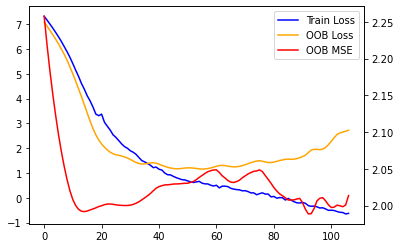

Bootstrap iteration 17 at time 2022-06-17 11:52:07.750727
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.394408702850342, MSE: 3.9944961071014404
Epoch: 0, Loss: 7.85673189163208, OOB Loss: 7.745368957519531, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8943320512771606, MSE: 2.570009231567383
Epoch: 40, Loss: 1.2514476776123047, OOB Loss: 1.815287470817566, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.208574056625366, MSE: 2.7479872703552246
Epoch: 80, Loss: 0.09179973602294922, OOB Loss: 1.936279535293579, LR: 0.00040823971994699836
Early stopped, best epoch: 45, train loss: 0.9175069332122803, best OOB loss: 1.6671059131622314, LR: 0.0003922127676914776


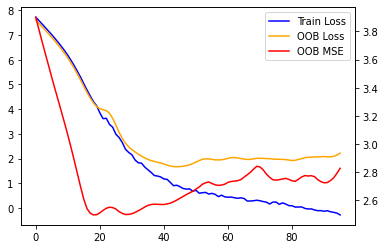

Bootstrap iteration 18 at time 2022-06-17 11:52:21.783767
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.632475852966309, MSE: 2.0058963298797607
Epoch: 0, Loss: 8.093464851379395, OOB Loss: 7.816931247711182, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.9043992757797241, MSE: 1.4590654373168945
Epoch: 40, Loss: 1.676920771598816, OOB Loss: 0.4937697649002075, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.1910817623138428, MSE: 1.3931294679641724
Epoch: 80, Loss: 0.5566494464874268, OOB Loss: 0.05707502365112305, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.85009503364563, MSE: 1.6343907117843628
Epoch: 120, Loss: -0.07651925086975098, OOB Loss: 1.0073864459991455, LR: 0.00036934432610923556
Early stopped, best epoch: 71, train loss: 0.7534379959106445, best OOB loss: 0.05141758918762207, LR: 0.0003674999128807276


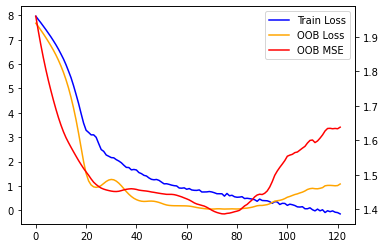

Bootstrap iteration 19 at time 2022-06-17 11:52:39.536244
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.078251361846924, MSE: 2.8486130237579346
Epoch: 0, Loss: 7.60772180557251, OOB Loss: 7.383965015411377, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.8303241729736328, MSE: 2.1344268321990967
Epoch: 40, Loss: 1.108741283416748, OOB Loss: 1.3141601085662842, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.4203922748565674, MSE: 2.1108756065368652
Epoch: 80, Loss: 0.08563971519470215, OOB Loss: 1.0617852210998535, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.249066114425659, MSE: 2.101808547973633
Epoch: 120, Loss: -0.6194579601287842, OOB Loss: 1.1461753845214844, LR: 0.00036934432610923556
Early stopped, best epoch: 81, train loss: 0.09495925903320312, best OOB loss: 1.0544641017913818, LR: 0.0003584150883524932


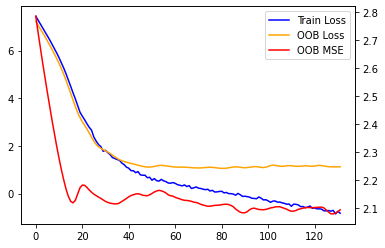

Bootstrap iteration 20 at time 2022-06-17 11:52:58.639849
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.48553466796875, MSE: 1.8608496189117432
Epoch: 0, Loss: 7.9423089027404785, OOB Loss: 7.647861003875732, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7185932397842407, MSE: 1.5091091394424438
Epoch: 40, Loss: 1.5919489860534668, OOB Loss: 0.6644951105117798, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.9173572063446045, MSE: 1.456674337387085
Epoch: 80, Loss: 0.22299408912658691, OOB Loss: 0.838233470916748, LR: 0.00040823971994699836
Early stopped, best epoch: 57, train loss: 0.8859236240386963, best OOB loss: 0.3605942726135254, LR: 0.00038060683174957196


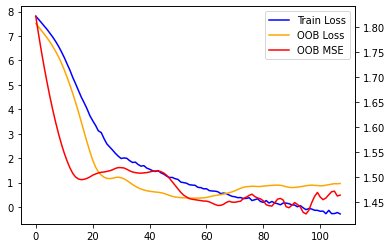

Bootstrap iteration 21 at time 2022-06-17 11:53:14.435059
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.419687747955322, MSE: 2.5415782928466797
Epoch: 0, Loss: 7.879083156585693, OOB Loss: 7.6688690185546875, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.725088357925415, MSE: 2.0306522846221924
Epoch: 40, Loss: 1.3156936168670654, OOB Loss: 1.5967204570770264, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.2272961139678955, MSE: 1.9341896772384644
Epoch: 80, Loss: 0.23640727996826172, OOB Loss: 1.292015552520752, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.9781181812286377, MSE: 2.130115509033203
Epoch: 120, Loss: -0.5103135108947754, OOB Loss: 2.090045213699341, LR: 0.00036934432610923556
Early stopped, best epoch: 75, train loss: 0.39811015129089355, best OOB loss: 1.25589120388031, LR: 0.0003638386720442643


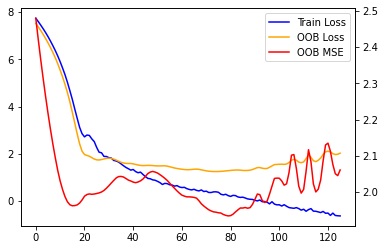

Bootstrap iteration 22 at time 2022-06-17 11:53:32.720528
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.512749671936035, MSE: 2.0072948932647705
Epoch: 0, Loss: 7.9263129234313965, OOB Loss: 7.705352306365967, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 1.7159138917922974, MSE: 1.6378977298736572
Epoch: 40, Loss: 1.348397970199585, OOB Loss: 0.8921514749526978, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.08666729927063, MSE: 1.5234500169754028
Epoch: 80, Loss: 0.21467852592468262, OOB Loss: 0.678030252456665, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 2.604732036590576, MSE: 1.5650372505187988
Epoch: 120, Loss: -0.3900184631347656, OOB Loss: 0.6708664894104004, LR: 0.00036934432610923556
Early stopped, best epoch: 105, train loss: -0.19981789588928223, best OOB loss: 0.6186923980712891, LR: 0.0003375172614958453


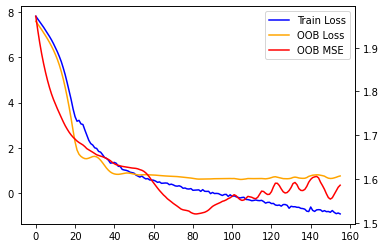

Bootstrap iteration 23 at time 2022-06-17 11:53:54.776574
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -7.650763988494873, MSE: 1.8766392469406128
Epoch: 0, Loss: 8.091649055480957, OOB Loss: 7.798993110656738, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.3777847290039062, MSE: 1.6073812246322632
Epoch: 40, Loss: 1.6409233808517456, OOB Loss: 0.7920181751251221, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 3.416111946105957, MSE: 1.5498915910720825
Epoch: 80, Loss: 0.5016956329345703, OOB Loss: 0.32439422607421875, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 4.629162788391113, MSE: 1.6134812831878662
Epoch: 120, Loss: -0.1548480987548828, OOB Loss: 1.1427483558654785, LR: 0.00036934432610923556
Early stopped, best epoch: 72, train loss: 0.6488511562347412, best OOB loss: 0.28299617767333984, LR: 0.0003665811630985258


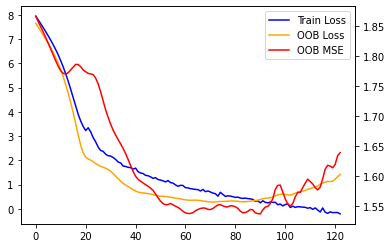

Bootstrap iteration 24 at time 2022-06-17 11:54:13.236839
Approximate NN size (MB):  84.7384033203125
OOB Mean Log Det Precision: -8.252104759216309, MSE: 3.036452531814575
Epoch: 0, Loss: 8.600489616394043, OOB Loss: 8.449939727783203, LR: 0.0004987500000000001
OOB Mean Log Det Precision: 2.6141929626464844, MSE: 2.0517523288726807
Epoch: 40, Loss: 1.3495526313781738, OOB Loss: 2.5204625129699707, LR: 0.00045123116063007594
OOB Mean Log Det Precision: 2.829230785369873, MSE: 1.8496676683425903
Epoch: 80, Loss: 0.31566548347473145, OOB Loss: 1.6994094848632812, LR: 0.00040823971994699836
OOB Mean Log Det Precision: 3.6087419986724854, MSE: 2.120426893234253
Epoch: 120, Loss: -0.2027113437652588, OOB Loss: 3.4537413120269775, LR: 0.00036934432610923556
Early stopped, best epoch: 88, train loss: 0.1343536376953125, best OOB loss: 1.6198539733886719, LR: 0.0003521896707677057


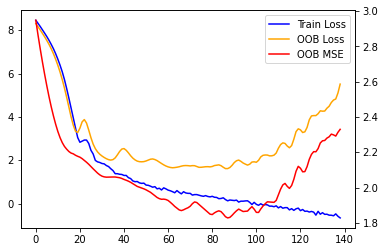

Time 0, 2022-06-17 11:54:32.570865
Time 5, 2022-06-17 12:10:27.156486
Time 10, 2022-06-17 12:26:18.861110
Time 15, 2022-06-17 12:42:07.622276
Time 20, 2022-06-17 12:57:48.339180
Time 25, 2022-06-17 13:13:32.684728
Time 30, 2022-06-17 13:29:13.697704
Time 35, 2022-06-17 13:44:55.404691
Time 40, 2022-06-17 14:00:45.827421
Time 45, 2022-06-17 14:16:38.882710
Time 50, 2022-06-17 14:32:29.983789
Time 55, 2022-06-17 14:48:20.030891
Time 60, 2022-06-17 15:04:15.425599
Time 65, 2022-06-17 15:20:05.369240
Time 70, 2022-06-17 15:35:55.149795
Time 75, 2022-06-17 15:51:47.553879
Time 80, 2022-06-17 16:07:40.215185
Time 85, 2022-06-17 16:23:33.469061
Size of x_mat before appending MARX (731, 6)
Size of x_mat_marx (731, 24)
x_mat_all size (731, 30)
Size of X_train afer appending time (731, 153) Time dummy setting: 2
x_pos {'inf': [0, 3], 'unrate': [1, 4], 'DGS3': [2, 5]}
Size of X_train (641, 153)
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Epoch: 0, Loss: 1.005078673362732, OOB Loss: 0.6557502746582031
Epoch: 40, Loss: 0.6615651845932007, OOB Loss: 0.5571590662002563
Epoch: 80, Loss: 0.5681661367416382, OOB Loss: 0.5264334678649902
Epoch: 120, Loss: 0.4681631028652191, OOB Loss: 0.5431236624717712
Early stopped, best epoch: 81, train loss: 0.5657644271850586, best OOB loss: 0.5255106687545776, LR: 0.0003584150883524932


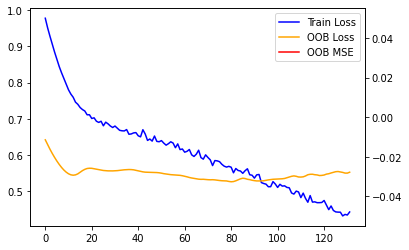

Bootstrap iteration 1 at time 2022-06-17 16:40:01.444554
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9766902923583984, OOB Loss: 1.0506463050842285
Epoch: 40, Loss: 0.6009392738342285, OOB Loss: 0.7983657121658325
Early stopped, best epoch: 27, train loss: 0.6331042647361755, best OOB loss: 0.7484713792800903, LR: 0.00041028859863643906


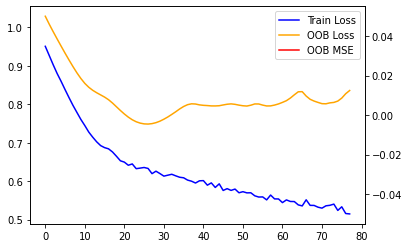

Bootstrap iteration 2 at time 2022-06-17 16:40:21.992620
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8483063578605652, OOB Loss: 1.4067966938018799
Epoch: 40, Loss: 0.5977939367294312, OOB Loss: 0.9592688083648682
Early stopped, best epoch: 25, train loss: 0.6054844856262207, best OOB loss: 0.897232711315155, LR: 0.00041234776026425864


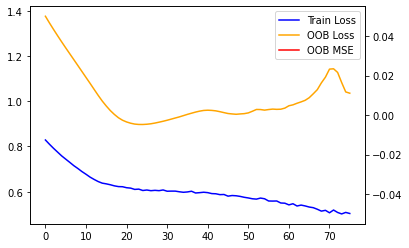

Bootstrap iteration 3 at time 2022-06-17 16:40:42.024901
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1512539386749268, OOB Loss: 0.6785327792167664
Epoch: 40, Loss: 0.6747612953186035, OOB Loss: 0.5343583226203918
Epoch: 80, Loss: 0.578766942024231, OOB Loss: 0.5076901912689209
Epoch: 120, Loss: 0.4890716075897217, OOB Loss: 0.5133373141288757
Early stopped, best epoch: 88, train loss: 0.5668811798095703, best OOB loss: 0.5060945749282837, LR: 0.0003521896707677057


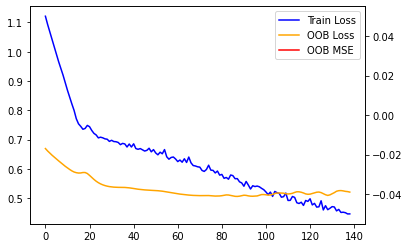

Bootstrap iteration 4 at time 2022-06-17 16:41:19.392554
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0078740119934082, OOB Loss: 0.4937988221645355
Epoch: 40, Loss: 0.6865329742431641, OOB Loss: 0.42068204283714294
Epoch: 80, Loss: 0.5438014268875122, OOB Loss: 0.4054808020591736
Epoch: 120, Loss: 0.4777817726135254, OOB Loss: 0.4013317823410034
Epoch: 160, Loss: 0.41865667700767517, OOB Loss: 0.4058349132537842
Early stopped, best epoch: 131, train loss: 0.446188747882843, best OOB loss: 0.39206457138061523, LR: 0.0003162507047527717


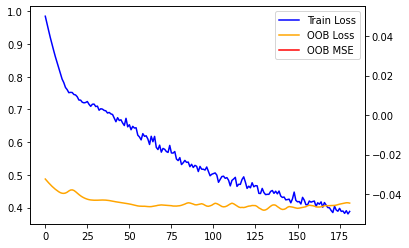

Bootstrap iteration 5 at time 2022-06-17 16:42:06.222234
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9733385443687439, OOB Loss: 1.0494694709777832
Epoch: 40, Loss: 0.5944861173629761, OOB Loss: 0.7486705780029297
Epoch: 80, Loss: 0.4641587734222412, OOB Loss: 0.7887498140335083
Early stopped, best epoch: 31, train loss: 0.6278896331787109, best OOB loss: 0.7309437990188599, LR: 0.0004062010728455131


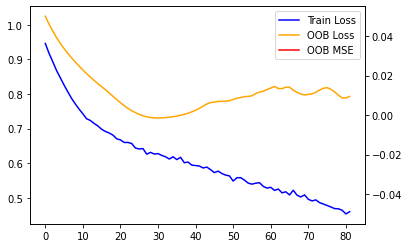

Bootstrap iteration 6 at time 2022-06-17 16:42:27.981044
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.2699131965637207, OOB Loss: 0.638737142086029
Epoch: 40, Loss: 0.6805566549301147, OOB Loss: 0.5455374121665955
Early stopped, best epoch: 13, train loss: 0.8030630946159363, best OOB loss: 0.5130338668823242, LR: 0.0004249215799968589


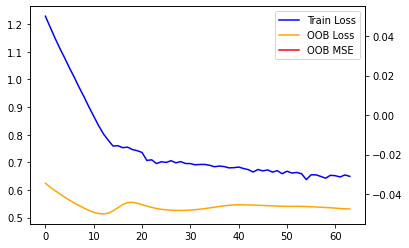

Bootstrap iteration 7 at time 2022-06-17 16:42:44.491779
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1641967296600342, OOB Loss: 0.500673770904541
Epoch: 40, Loss: 0.721042811870575, OOB Loss: 0.33234691619873047
Epoch: 80, Loss: 0.6157923936843872, OOB Loss: 0.32166534662246704
Epoch: 120, Loss: 0.5185542106628418, OOB Loss: 0.32524263858795166
Early stopped, best epoch: 90, train loss: 0.59437495470047, best OOB loss: 0.31880590319633484, LR: 0.0003504309235993095


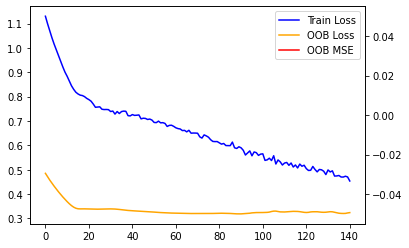

Bootstrap iteration 8 at time 2022-06-17 16:43:21.457174
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.155210256576538, OOB Loss: 0.4987451434135437
Epoch: 40, Loss: 0.7116646766662598, OOB Loss: 0.4243297576904297
Epoch: 80, Loss: 0.6092516779899597, OOB Loss: 0.4116307497024536
Early stopped, best epoch: 66, train loss: 0.6442136764526367, best OOB loss: 0.40843290090560913, LR: 0.0003721283168945075


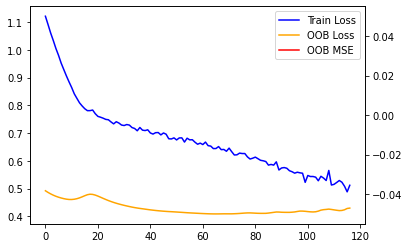

Bootstrap iteration 9 at time 2022-06-17 16:43:52.282621
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.071484088897705, OOB Loss: 0.8182357549667358
Epoch: 40, Loss: 0.6702868342399597, OOB Loss: 0.5329380035400391
Early stopped, best epoch: 19, train loss: 0.7346088290214539, best OOB loss: 0.5182042121887207, LR: 0.00041858746015576575


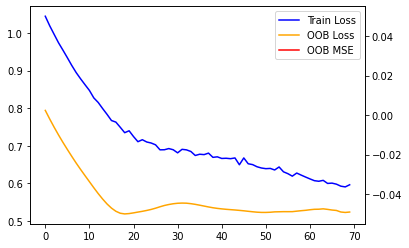

Bootstrap iteration 10 at time 2022-06-17 16:44:10.600866
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8999912738800049, OOB Loss: 1.1086655855178833
Epoch: 40, Loss: 0.5723473429679871, OOB Loss: 0.908007025718689
Epoch: 80, Loss: 0.4958591163158417, OOB Loss: 1.0483920574188232
Early stopped, best epoch: 37, train loss: 0.5899171233177185, best OOB loss: 0.9038205146789551, LR: 0.0004001460114033451


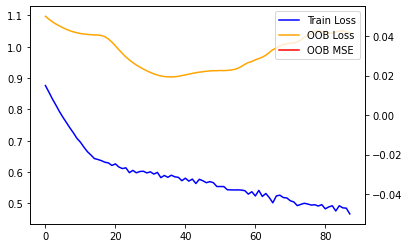

Bootstrap iteration 11 at time 2022-06-17 16:44:34.073217
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0812742710113525, OOB Loss: 0.7308043837547302
Epoch: 40, Loss: 0.6898303031921387, OOB Loss: 0.45294755697250366
Epoch: 80, Loss: 0.5980062484741211, OOB Loss: 0.43974217772483826
Epoch: 120, Loss: 0.4987116754055023, OOB Loss: 0.43535932898521423
Early stopped, best epoch: 102, train loss: 0.5283659100532532, best OOB loss: 0.4333464503288269, LR: 0.0003400613507899008


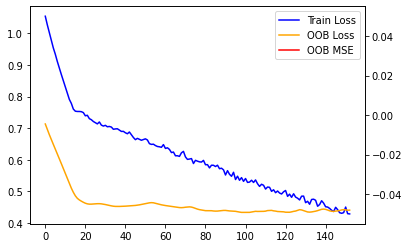

Bootstrap iteration 12 at time 2022-06-17 16:45:13.961939
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9601364135742188, OOB Loss: 0.42304739356040955
Epoch: 40, Loss: 0.6887618899345398, OOB Loss: 0.40866726636886597
Epoch: 80, Loss: 0.5875279903411865, OOB Loss: 0.37717145681381226
Epoch: 120, Loss: 0.48863857984542847, OOB Loss: 0.37800878286361694
Early stopped, best epoch: 104, train loss: 0.5294409990310669, best OOB loss: 0.372938871383667, LR: 0.00033836316941939377


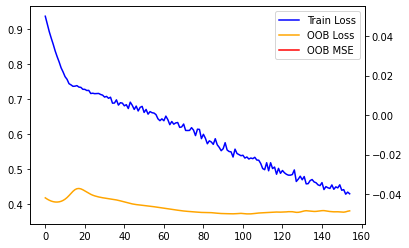

Bootstrap iteration 13 at time 2022-06-17 16:45:54.169130
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.7311059832572937, OOB Loss: 1.4692723751068115
Epoch: 40, Loss: 0.505172848701477, OOB Loss: 1.2025030851364136
Epoch: 80, Loss: 0.43136847019195557, OOB Loss: 1.4819872379302979
Early stopped, best epoch: 48, train loss: 0.4948803782463074, best OOB loss: 1.1754652261734009, LR: 0.0003892785197948613


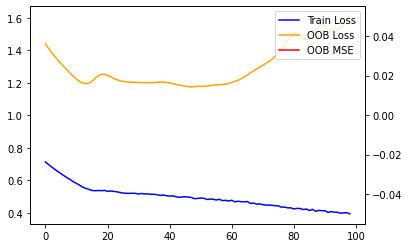

Bootstrap iteration 14 at time 2022-06-17 16:46:19.662528
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.2220450639724731, OOB Loss: 0.6844109892845154
Epoch: 40, Loss: 0.6683396100997925, OOB Loss: 0.5432367324829102
Epoch: 80, Loss: 0.5923666954040527, OOB Loss: 0.5088874101638794
Epoch: 120, Loss: 0.4993407726287842, OOB Loss: 0.5220307111740112
Early stopped, best epoch: 101, train loss: 0.5395026206970215, best OOB loss: 0.4992610216140747, LR: 0.00034091363487709353


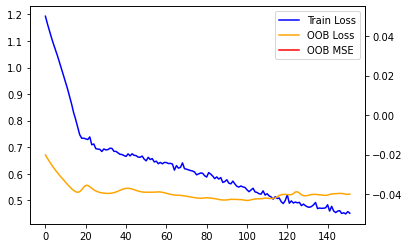

Bootstrap iteration 15 at time 2022-06-17 16:46:58.706390
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8573290705680847, OOB Loss: 0.9933395385742188
Epoch: 40, Loss: 0.6275749206542969, OOB Loss: 0.7525777220726013
Early stopped, best epoch: 25, train loss: 0.6412591934204102, best OOB loss: 0.7298456430435181, LR: 0.00041234776026425864


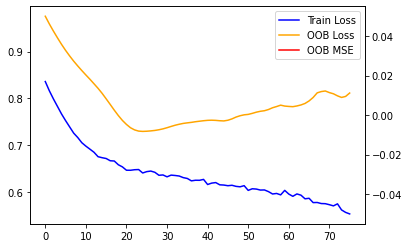

Bootstrap iteration 16 at time 2022-06-17 16:47:18.703849
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.7379912734031677, OOB Loss: 1.252821922302246
Epoch: 40, Loss: 0.5468236207962036, OOB Loss: 1.0207443237304688
Epoch: 80, Loss: 0.46867501735687256, OOB Loss: 1.3175153732299805
Early stopped, best epoch: 31, train loss: 0.5641211271286011, best OOB loss: 0.9677985906600952, LR: 0.0004062010728455131


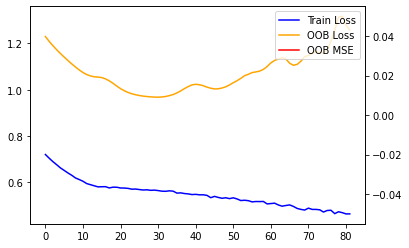

Bootstrap iteration 17 at time 2022-06-17 16:47:40.433334
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.8760262727737427, OOB Loss: 1.2890501022338867
Epoch: 40, Loss: 0.5523392558097839, OOB Loss: 0.9747943878173828
Early stopped, best epoch: 27, train loss: 0.5750893950462341, best OOB loss: 0.9358009099960327, LR: 0.00041028859863643906


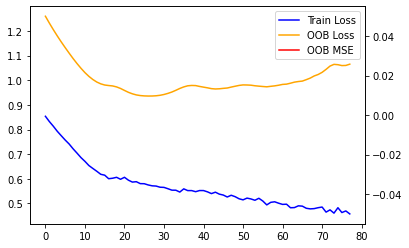

Bootstrap iteration 18 at time 2022-06-17 16:48:01.014745
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.1161835193634033, OOB Loss: 0.6733136177062988
Epoch: 40, Loss: 0.682925820350647, OOB Loss: 0.47289788722991943
Epoch: 80, Loss: 0.5976235866546631, OOB Loss: 0.45580539107322693
Epoch: 120, Loss: 0.5175827741622925, OOB Loss: 0.4548555612564087
Epoch: 160, Loss: 0.4358753561973572, OOB Loss: 0.46769702434539795
Early stopped, best epoch: 118, train loss: 0.5019994974136353, best OOB loss: 0.45264720916748047, LR: 0.00032671099126641977


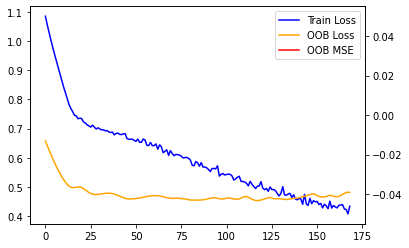

Bootstrap iteration 19 at time 2022-06-17 16:48:43.571558
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9755125045776367, OOB Loss: 0.6162487268447876
Epoch: 40, Loss: 0.6912667155265808, OOB Loss: 0.47740837931632996
Epoch: 80, Loss: 0.5780069231987, OOB Loss: 0.4867421090602875
Early stopped, best epoch: 47, train loss: 0.6722598075866699, best OOB loss: 0.4740266799926758, LR: 0.00039025415518281834


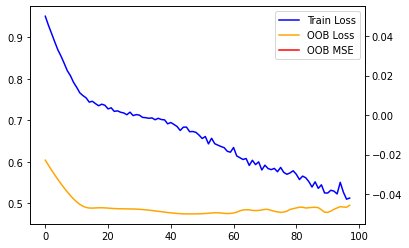

Bootstrap iteration 20 at time 2022-06-17 16:49:09.428088
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.055387258529663, OOB Loss: 1.0703778266906738
Epoch: 40, Loss: 0.6121445894241333, OOB Loss: 0.717664361000061
Early stopped, best epoch: 17, train loss: 0.674970269203186, best OOB loss: 0.7040398120880127, LR: 0.0004206882722151401


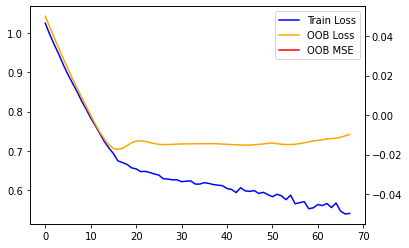

Bootstrap iteration 21 at time 2022-06-17 16:49:27.259988
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.934903621673584, OOB Loss: 0.839512825012207
Epoch: 40, Loss: 0.6329228281974792, OOB Loss: 0.6607294082641602
Epoch: 80, Loss: 0.5485191345214844, OOB Loss: 0.6616670489311218
Epoch: 120, Loss: 0.47846007347106934, OOB Loss: 0.6728546023368835
Early stopped, best epoch: 103, train loss: 0.49878811836242676, best OOB loss: 0.6571488380432129, LR: 0.0003392111974129261


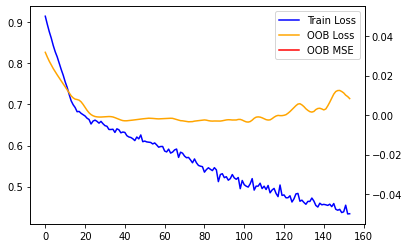

Bootstrap iteration 22 at time 2022-06-17 16:50:06.724729
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9755789637565613, OOB Loss: 0.9358586668968201
Epoch: 40, Loss: 0.6319908499717712, OOB Loss: 0.6733375787734985
Epoch: 80, Loss: 0.5526102781295776, OOB Loss: 0.711953341960907
Early stopped, best epoch: 48, train loss: 0.6123501062393188, best OOB loss: 0.65782630443573, LR: 0.0003892785197948613


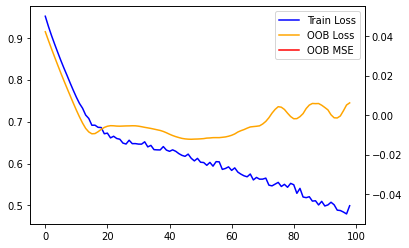

Bootstrap iteration 23 at time 2022-06-17 16:50:31.910735
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 1.0778886079788208, OOB Loss: 0.48420482873916626
Epoch: 40, Loss: 0.7097262740135193, OOB Loss: 0.3963514566421509
Epoch: 80, Loss: 0.6189050078392029, OOB Loss: 0.39589831233024597
Epoch: 120, Loss: 0.5137745141983032, OOB Loss: 0.43449896574020386
Early stopped, best epoch: 70, train loss: 0.6515023708343506, best OOB loss: 0.3928781747817993, LR: 0.0003684209652939625


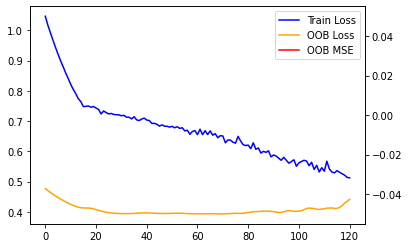

Bootstrap iteration 24 at time 2022-06-17 16:51:03.051232
Approximate NN size (MB):  84.7384033203125
Epoch: 0, Loss: 0.9562257528305054, OOB Loss: 1.2357652187347412
Epoch: 40, Loss: 0.5990162491798401, OOB Loss: 0.8152326941490173
Epoch: 80, Loss: 0.47841677069664, OOB Loss: 0.977181613445282
Early stopped, best epoch: 47, train loss: 0.5790606737136841, best OOB loss: 0.8086551427841187, LR: 0.00039123223577224893


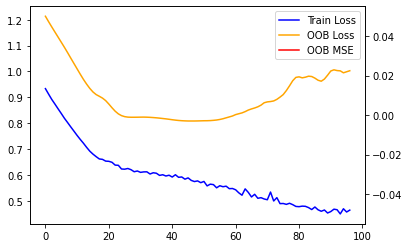

Time 0, 2022-06-17 16:51:29.059072
Time 5, 2022-06-17 17:07:21.880975
Time 10, 2022-06-17 17:23:18.090140
Time 15, 2022-06-17 17:39:12.489077
Time 20, 2022-06-17 17:55:00.043039
Time 25, 2022-06-17 18:10:40.000824
Time 30, 2022-06-17 18:26:21.078052
Time 35, 2022-06-17 18:42:03.428256
Time 40, 2022-06-17 18:57:46.558127
Time 45, 2022-06-17 19:13:25.898073
Time 50, 2022-06-17 19:29:06.480902
Time 55, 2022-06-17 19:44:51.370519
Time 60, 2022-06-17 20:00:33.181068
Time 65, 2022-06-17 20:16:13.375119
Time 70, 2022-06-17 20:31:57.496073
Time 75, 2022-06-17 20:47:43.069159
Time 80, 2022-06-17 21:03:29.717222
Time 85, 2022-06-17 21:19:14.608372


In [ ]:
experiment_name = '15jun_multi_forecasting'
test_size = T

folder_path = f'drive/MyDrive/EconML DL/2022 Experiments/{experiment_name}'
if os.path.isdir(folder_path) == False:
  os.mkdir(folder_path)
else:
  print('Folder already exists')

for variable_list in variable_lists:
  # Select variables for experiment
  print('Variables', variable_list)
  x_d = x_d_all.copy()
  x_d = x_d[variable_list]
  x_d_colnames = x_d.columns
  var_names = x_d.columns
  n_var = len(var_names)
  nn_hyps['variable_list'] = variable_list

  train_size = x_d.shape[0] - test_size - nn_hyps['n_lag_d']
  if nn_hyps['fix_bootstrap'] == True:
    bootstrap_indices = get_bootstrap_indices(num_bootstrap = num_inner_bootstraps, n_obs = train_size, block_size = nn_hyps['block_size'], sampling_rate = nn_hyps['sampling_rate'], opt_bootstrap = nn_hyps['opt_bootstrap'])
    nn_hyps['bootstrap_indices'] = bootstrap_indices
  else:
    nn_hyps['bootstrap_indices'] = None

  # Save experiment param list
  with open(f'{folder_path}/params.npz', 'wb') as f:
      np.savez(f, params = experiment_params, date = datetime.now())

  for repeat in range(num_repeats):
    for i in range(len(experiment_params)):

      nn_hyps.update(experiment_params[i])

      n_betas = n_var * nn_hyps['n_lag_linear'] + 1
      n_inputs_wo_time = n_var * (nn_hyps['n_lag_linear'] + nn_hyps['n_lag_d'])

      X_train, X_test, Y_train, Y_test, x_mat_all, y_mat, nn_hyps = process_varnn_data(x_d, nn_hyps, test_size = test_size, n_time_trends = 100, time_dummy_setting = nn_hyps['time_dummy_setting'], marx = nn_hyps['marx'], dummy_interval = nn_hyps['dummy_interval'])

      n_inputs_total = X_train.shape[1]
      nn_hyps['neurons_weights'] = [nn_hyps['tvpl_archi'] for i in range(n_betas)]

      # If s_pos is already not defined (s_pos can be defined by user)
      if not nn_hyps.get('s_pos'):
        # s_pos_setting
        if nn_hyps['s_pos_setting']['is_hemi'] == False:
          nn_hyps['s_pos'] = [ list(range(n_inputs_total)) ]
        else:
          n_inputs_total_new = n_inputs_wo_time + nn_hyps['s_pos_setting']['n_times']
          nn_hyps['s_pos'] = [ list(range(n_inputs_wo_time)), list(range(n_inputs_wo_time, n_inputs_total_new))]
          # Subset the X_train and X_test to only the required columns
          X_train = X_train[:, :n_inputs_total_new]
          X_test = X_test[:, :n_inputs_total_new]
      print(nn_hyps['s_pos'])

      ### FORECASTING NEW CODE
      # Fix the shock ids across the different models
      error_ids = np.array(random.choices(range(X_train.shape[0]), k = h * B * T))
      error_ids = error_ids.reshape((h, B, T))

      # Test prediction array
      FCAST = np.zeros((h+1, n_var, B, T, R))
      FCAST[:] = np.nan

      for r in range(R):
        print(f'Re-estimation window {r}, {datetime.now()}')

        # Training data is the data available till that moment
        X_train = x_mat_all[:-(test_size - reestimation_window * r), :]
        Y_train = y_mat[:-(test_size - reestimation_window * r), :]

        results = conduct_bootstrap(X_train, X_test, Y_train, Y_test, nn_hyps, device)

        if r == 0:
          BETAS = results['betas_draws']
          BETAS_IN = results['betas_in_draws']
          SIGMAS = results['sigmas_draws']
          SIGMAS_IN = results['sigmas_in_draws']
          PRECISION = results['precision_draws']
          PRECISION_IN = results['precision_in_draws']
          CHOLESKY = results['cholesky_draws']
          CHOLESKY_IN = results['cholesky_in_draws']
          PREDS = results['pred_in_ensemble'] 
          PREDS_TEST = results['pred_ensemble']

          with open(f'{folder_path}/{n_var}var_params_{i}_repeat_{repeat}.npz', 'wb') as f:
            np.savez(f, betas = BETAS, betas_in = BETAS_IN, 
                    sigmas = SIGMAS, sigmas_in = SIGMAS_IN,
                    precision = PRECISION, precision_in = PRECISION_IN,
                    cholesky = CHOLESKY, cholesky_in = CHOLESKY_IN,
                    train_preds = PREDS, test_preds = PREDS_TEST, 
                    y = Y_train, y_test = Y_test, 
                    params = nn_hyps)
            
        # For every timestep (in the future), for every bootstrap, get the h-th horizon prediction
        for t in range(r * reestimation_window, T):
          if t % 5 == 0:
            print(f'Time {t}, {datetime.now()}')
          for b in range(B):
            if t == r * reestimation_window: # first sample (X_train is continually changed so can take last value of X_train)
              FCAST[:, :, b, t, r] = predict_one_bootstrap(X_train[-1, :], results, error_ids[:, b, t], nn_hyps)
            else: # not the first sample (X_test is unchanged so can just index t)
              FCAST[:, :, b, t, r] = predict_one_bootstrap(X_test[t, :], results, error_ids[:, b, t], nn_hyps)
        
      del nn_hyps['s_pos']

      with open(f'{folder_path}/params_{i}_forecasting_repeat_{repeat}.npz', 'wb') as f:
        np.save(f, FCAST)

### Benchmarks to compare VARNN Against

In [20]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA

n_lag_linear = 2

In [40]:
experiment_name = '6jul_multi_forecasting'
test_size = T

folder_path = f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}'
if os.path.isdir(folder_path) == False:
  os.mkdir(folder_path)
else:
  print('Folder already exists')

Folder already exists


In [44]:
variable_list = variable_lists[0]
x_d = x_d_all.copy()
x_d = x_d[variable_list]
x_d_colnames = x_d.columns
var_names = x_d.columns
n_var = len(var_names)

In [45]:
### Expanding Window VAR

# Test prediction array
FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

data = np.array(data)
Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment
  Y_train = data[:-(T - reestimation_window * r), :]
  
  # Estimate the VAR model with available data
  var_model = VAR(Y_train)
  results = var_model.fit(n_lag_linear)
  for t in range(reestimation_window * r, T):
    if t == reestimation_window * r:
      FCAST[1:, :, t, r] = results.forecast(Y_train[-n_lag_linear:, :], steps = h)
    # In between case when you need to combine Y_train and some bit of Y_test
    elif t < reestimation_window * r + n_lag_linear:
      train_obs_needed = n_lag_linear - (t - reestimation_window * r)
      test_obs_needed = t - reestimation_window * r
      Y_in = np.concatenate([Y_train[-train_obs_needed:, :], Y_test[:test_obs_needed, :]], axis = 0)
      FCAST[1:, :, t, r] = results.forecast(Y_in, steps = h)
    else:
      FCAST[1:, :, t, r] = results.forecast(Y_test[(t-n_lag_linear):t, :], steps = h)

with open(f'{folder_path}/expanding_var_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-07-06 18:26:20.902790


In [46]:
### Rolling Window VAR

# Test prediction array
FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

window_length = 40
Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment - *restricted to the length of window
  Y_train = data[-(T - reestimation_window * r + window_length):-(T - reestimation_window * r), :]
  # Estimate the VAR model with available data
  var_model = VAR(Y_train)
  results = var_model.fit(n_lag_linear)
  for t in range(reestimation_window * r, T):
    if t == reestimation_window * r:
      FCAST[1:, :, t, r] = results.forecast(Y_train[-n_lag_linear:, :], steps = h)
    # In between case when you need to combine Y_train and some bit of Y_test
    elif t < reestimation_window * r + n_lag_linear:
      train_obs_needed = n_lag_linear - (t - reestimation_window * r)
      test_obs_needed = t - reestimation_window * r
      Y_in = np.concatenate([Y_train[-train_obs_needed:, :], Y_test[:test_obs_needed, :]], axis = 0)
      FCAST[1:, :, t, r] = results.forecast(Y_in, steps = h)
    else:
      FCAST[1:, :, t, r] = results.forecast(Y_test[(t-n_lag_linear):t, :], steps = h)

with open(f'{folder_path}/rolling_var_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-07-06 18:26:23.156261


In [47]:
def get_ar_forecasts(y_in, results_coefs, h):
  # y_in should be of length 'ar_lags' - all you need to start iterating forward
  
  # Store both train and test 
  y_all = np.zeros((y_in.shape[0] + h))
  y_all[:] = np.nan
  y_all[:y_in.shape[0]] = y_in

  for horizon in range(1, h+1):
    # Get the input lags for 
    y_in_this = y_all[(y_in.shape[0] -1 -4 + horizon):(y_in.shape[0] -1 + horizon)]
    # Evaluate the AR equation to get the prediction
    y_all[y_in.shape[0] - 1 + horizon] = results_coefs[0] + np.dot(results_coefs[1:], y_in)

  # Return h predictions
  return y_all[y_in.shape[0]:]

In [48]:
### Expanding Window AR(4)

reestimation_window = 1
R = int(T / reestimation_window)

ar_lags = 4

FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment
  Y_train = data[:-(T - reestimation_window * r), :]

  if Y_train.shape[0] != 0:

    for var in range(n_var):
      y_train = Y_train[:, var]
      y_test = Y_test[:, var]
      arima_model = ARIMA(y_train, order = (ar_lags,0,0))
      results = arima_model.fit()
      results_coefs = results.params[0:(ar_lags + 1)]
    
      for t in range(reestimation_window * r, T):
        # Different cases of getting the input y_in
        if t == reestimation_window * r:
          y_in = y_train[-ar_lags:]
        # In between case when you need to combine Y_train and some bit of Y_test
        elif t < reestimation_window * r + ar_lags:
          train_obs_needed = ar_lags - (t - reestimation_window * r)
          test_obs_needed = t - reestimation_window * r
          y_in = np.concatenate([y_train[-train_obs_needed:], y_test[:test_obs_needed]], axis = 0)
        else:
          y_in = y_test[(t-ar_lags):t]

        FCAST[1:, var, t, r] = get_ar_forecasts(y_in, results_coefs, h)

with open(f'{folder_path}/expanding_ar_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-07-06 18:26:25.826451
Re-estimation window 1, 2022-07-06 18:26:27.294855
Re-estimation window 2, 2022-07-06 18:26:28.862544
Re-estimation window 3, 2022-07-06 18:26:30.257285
Re-estimation window 4, 2022-07-06 18:26:31.370943
Re-estimation window 5, 2022-07-06 18:26:32.514840
Re-estimation window 6, 2022-07-06 18:26:33.918557


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 7, 2022-07-06 18:26:35.794082
Re-estimation window 8, 2022-07-06 18:26:37.178339


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 9, 2022-07-06 18:26:39.117426
Re-estimation window 10, 2022-07-06 18:26:40.648553
Re-estimation window 11, 2022-07-06 18:26:41.793794
Re-estimation window 12, 2022-07-06 18:26:43.159463
Re-estimation window 13, 2022-07-06 18:26:44.416477
Re-estimation window 14, 2022-07-06 18:26:45.548001
Re-estimation window 15, 2022-07-06 18:26:47.068669
Re-estimation window 16, 2022-07-06 18:26:48.673120
Re-estimation window 17, 2022-07-06 18:26:50.073626
Re-estimation window 18, 2022-07-06 18:26:51.484186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 19, 2022-07-06 18:26:53.366920
Re-estimation window 20, 2022-07-06 18:26:54.710637
Re-estimation window 21, 2022-07-06 18:26:56.135095
Re-estimation window 22, 2022-07-06 18:26:57.535678
Re-estimation window 23, 2022-07-06 18:26:59.066496
Re-estimation window 24, 2022-07-06 18:27:00.559673
Re-estimation window 25, 2022-07-06 18:27:02.741876


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 26, 2022-07-06 18:27:04.617850


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 27, 2022-07-06 18:27:06.524778
Re-estimation window 28, 2022-07-06 18:27:08.214521
Re-estimation window 29, 2022-07-06 18:27:09.610369
Re-estimation window 30, 2022-07-06 18:27:10.775939
Re-estimation window 31, 2022-07-06 18:27:11.966568
Re-estimation window 32, 2022-07-06 18:27:13.221074
Re-estimation window 33, 2022-07-06 18:27:14.746640
Re-estimation window 34, 2022-07-06 18:27:16.256527
Re-estimation window 35, 2022-07-06 18:27:17.717716
Re-estimation window 36, 2022-07-06 18:27:19.536361
Re-estimation window 37, 2022-07-06 18:27:21.041448
Re-estimation window 38, 2022-07-06 18:27:22.440236
Re-estimation window 39, 2022-07-06 18:27:23.854727
Re-estimation window 40, 2022-07-06 18:27:25.332137
Re-estimation window 41, 2022-07-06 18:27:26.774204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 42, 2022-07-06 18:27:28.724644


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 43, 2022-07-06 18:27:30.762322


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 44, 2022-07-06 18:27:32.818858
Re-estimation window 45, 2022-07-06 18:27:34.375401
Re-estimation window 46, 2022-07-06 18:27:35.883489
Re-estimation window 47, 2022-07-06 18:27:37.431224
Re-estimation window 48, 2022-07-06 18:27:39.062927
Re-estimation window 49, 2022-07-06 18:27:40.463388
Re-estimation window 50, 2022-07-06 18:27:41.844429
Re-estimation window 51, 2022-07-06 18:27:43.304904


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 52, 2022-07-06 18:27:45.374999
Re-estimation window 53, 2022-07-06 18:27:46.822028
Re-estimation window 54, 2022-07-06 18:27:48.374902
Re-estimation window 55, 2022-07-06 18:27:49.858169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 56, 2022-07-06 18:27:51.955929
Re-estimation window 57, 2022-07-06 18:27:53.559270
Re-estimation window 58, 2022-07-06 18:27:55.173542


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 59, 2022-07-06 18:27:57.220494


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [49]:
### Rolling Window AR(4)

reestimation_window = 1
R = int(T / reestimation_window)

ar_lags = 4

FCAST = np.zeros((h+1, n_var, T, R))
FCAST[:] = np.nan

window_length = 40

Y_test = data[-T:, :]

# For every time through the re-estimation window
for r in range(R):
  print(f'Re-estimation window {r}, {datetime.now()}')
  data = np.array(x_d)
  # Training data is the data available till that moment
  Y_train = data[-(T - reestimation_window * r + window_length):-(T - reestimation_window * r), :]

  if Y_train.shape[0] != 0:

    for var in range(n_var):
      y_train = Y_train[:, var]
      y_test = Y_test[:, var]
      arima_model = ARIMA(y_train, order = (ar_lags,0,0))
      results = arima_model.fit()
      results_coefs = results.params[0:(ar_lags + 1)]
    
      for t in range(reestimation_window * r, T):
        # Different cases of getting the input y_in
        if t == reestimation_window * r:
          y_in = y_train[-ar_lags:]
        # In between case when you need to combine Y_train and some bit of Y_test
        elif t < reestimation_window * r + ar_lags:
          train_obs_needed = ar_lags - (t - reestimation_window * r)
          test_obs_needed = t - reestimation_window * r
          y_in = np.concatenate([y_train[-train_obs_needed:], y_test[:test_obs_needed]], axis = 0)
        else:
          y_in = y_test[(t-ar_lags):t]

        FCAST[1:, var, t, r] = get_ar_forecasts(y_in, results_coefs, h)

with open(f'{folder_path}/rolling_ar_forecasting.npz', 'wb') as f:
    np.save(f, FCAST)

Re-estimation window 0, 2022-07-06 18:27:59.430514
Re-estimation window 1, 2022-07-06 18:28:00.026968
Re-estimation window 2, 2022-07-06 18:28:00.468672
Re-estimation window 3, 2022-07-06 18:28:00.918877
Re-estimation window 4, 2022-07-06 18:28:01.473564
Re-estimation window 5, 2022-07-06 18:28:02.031793
Re-estimation window 6, 2022-07-06 18:28:02.488107


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 7, 2022-07-06 18:28:03.073713
Re-estimation window 8, 2022-07-06 18:28:03.487446
Re-estimation window 9, 2022-07-06 18:28:03.909685
Re-estimation window 10, 2022-07-06 18:28:04.297046


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 11, 2022-07-06 18:28:04.941232
Re-estimation window 12, 2022-07-06 18:28:05.350257


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 13, 2022-07-06 18:28:05.861719


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 14, 2022-07-06 18:28:06.536437


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 15, 2022-07-06 18:28:07.115894
Re-estimation window 16, 2022-07-06 18:28:07.495995
Re-estimation window 17, 2022-07-06 18:28:07.932839
Re-estimation window 18, 2022-07-06 18:28:08.456183
Re-estimation window 19, 2022-07-06 18:28:08.874514
Re-estimation window 20, 2022-07-06 18:28:09.237238
Re-estimation window 21, 2022-07-06 18:28:09.657144
Re-estimation window 22, 2022-07-06 18:28:10.090970
Re-estimation window 23, 2022-07-06 18:28:10.445231
Re-estimation window 24, 2022-07-06 18:28:10.747544


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 25, 2022-07-06 18:28:11.233981
Re-estimation window 26, 2022-07-06 18:28:11.634623
Re-estimation window 27, 2022-07-06 18:28:11.973520


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 28, 2022-07-06 18:28:12.574559
Re-estimation window 29, 2022-07-06 18:28:13.048670
Re-estimation window 30, 2022-07-06 18:28:13.482209
Re-estimation window 31, 2022-07-06 18:28:13.978148
Re-estimation window 32, 2022-07-06 18:28:14.382558
Re-estimation window 33, 2022-07-06 18:28:14.693857


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 34, 2022-07-06 18:28:15.209275


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 35, 2022-07-06 18:28:15.774032
Re-estimation window 36, 2022-07-06 18:28:16.149058


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 37, 2022-07-06 18:28:16.719560
Re-estimation window 38, 2022-07-06 18:28:17.192614
Re-estimation window 39, 2022-07-06 18:28:17.641125
Re-estimation window 40, 2022-07-06 18:28:18.006905
Re-estimation window 41, 2022-07-06 18:28:18.331489
Re-estimation window 42, 2022-07-06 18:28:18.699565
Re-estimation window 43, 2022-07-06 18:28:19.108714
Re-estimation window 44, 2022-07-06 18:28:19.520592
Re-estimation window 45, 2022-07-06 18:28:19.938203


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 46, 2022-07-06 18:28:20.428990
Re-estimation window 47, 2022-07-06 18:28:20.778411
Re-estimation window 48, 2022-07-06 18:28:21.214744


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 49, 2022-07-06 18:28:21.674358
Re-estimation window 50, 2022-07-06 18:28:22.037608
Re-estimation window 51, 2022-07-06 18:28:22.318558
Re-estimation window 52, 2022-07-06 18:28:22.675484
Re-estimation window 53, 2022-07-06 18:28:23.073747
Re-estimation window 54, 2022-07-06 18:28:23.418952
Re-estimation window 55, 2022-07-06 18:28:23.900916
Re-estimation window 56, 2022-07-06 18:28:24.267201
Re-estimation window 57, 2022-07-06 18:28:24.668535


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Re-estimation window 58, 2022-07-06 18:28:25.263493
Re-estimation window 59, 2022-07-06 18:28:25.639451
